# AutoML with TPOT using Adversary Emulation (C2) as datagen - Supervised and Deep Learning with Genetic Programming

>[AutoML with TPOT using Adversary Emulation (C2) as datagen - Supervised and Deep Learning with Genetic Programming](#scrollTo=YJeseKzwjOVm)

>[Installations](#scrollTo=Fv4KCLz9j4Zc)

>[Tpot can use RAPIDS for better GPU support](#scrollTo=67jTk-_N42-A)

>[Initialize GitHub authentication (token)](#scrollTo=OQTe2IE95P7c)

>[Data download: captured Sysmon logs from the AE lab](#scrollTo=oYVNy4rNojZc)

>>[ML development Objectives](#scrollTo=oYVNy4rNojZc)

>[Download pre-trained BPE Tokenizer from the project](#scrollTo=Uyn6jyZvMsQI)

>[ETL and labeling](#scrollTo=qM4Ym_5Zon4w)

>[Sorting the data to get a timeline](#scrollTo=tKBQ5qsaBH02)

>[Denoised vector generation through message filtering](#scrollTo=cYjpfMq1qKb1)

>[Data exploration: create extra tables for labelling](#scrollTo=E_THJfYFmgLc)

>[Qualitative behaviour analysis: temporary folder on Windows 10](#scrollTo=IuK7hfb_mq8e)

>[Quantitative behaviour analysis: How many "bad" conditions did this yield?](#scrollTo=mVu5858Xm8qU)

>[Store the data as CSV and JSON](#scrollTo=BGPg1RDmxMVE)

>[Labeling based on Python](#scrollTo=GgFNrU80xQsF)

>[Check of the Adversary Emulation data: a simulation dataset for InfoSec](#scrollTo=MES2a9BdnkU4)

>[Vectorization with Linformer](#scrollTo=9-1dkT2mQHvJ)

>[Example messages from the two classes (for a single-label classifier)](#scrollTo=91khWgQT3DVa)

>[Example messages from the two classes (for a single-label classifier) (pandas framework code)](#scrollTo=ZY-8c7Q_3mEg)

>[Vectorize text column in the DataFrame](#scrollTo=h4cuBLWrSNVs)

>[The following code performs the high-dimensional vector projection with the Linformer model](#scrollTo=kSVB7YH-4czH)

>[Saving the vectorized dataset as Parquet](#scrollTo=ScKF9UeB66LK)

>[Import the data](#scrollTo=7LTDH-8RecLy)

>[Kaggle download: log2ml dataset with Adversary Emulation data](#scrollTo=zmJzQP08sFfd)

>[Import the parquet file into polars with pandas](#scrollTo=g7Tzv9jXsLWs)

>[Load data into pandas](#scrollTo=_LydloD7sczq)

>[AutoML with TPOT (Supervised Learning)](#scrollTo=ZqGIRBU6aE3U)

>[Sparse vector data](#scrollTo=0Xxcb4ITMAH_)

>[TPOT for Supervised Learning with Algo stats](#scrollTo=Gf4Fu4cDs4pr)

>[TPOT Algo Stats: Supervised Learning](#scrollTo=KYJ1AkAStACV)

>[Model export: TPOT's best pipeline, Supervised](#scrollTo=vM6TVwHYtKNa)

>[Evaluation of the model](#scrollTo=lqXIlzZ0u7oN)

>[Handling Imbalanced Data](#scrollTo=RG5bRw2lt0GD)

>[Testing the predictions](#scrollTo=zCJ3jHyZQIS_)

>[Save the Supervised Learning Model (joblib)](#scrollTo=YVPPGLSA6uZ-)

>[Confusion matrix](#scrollTo=l1u70hEaAYgD)

>[CV scores](#scrollTo=0jtLBuvnAeND)

>[Grid search optimization](#scrollTo=_XUIxpRdKzf9)

>[Tpot (Supervised)](#scrollTo=ZWRH59wKLaAX)

>[Building a NN classifier with Tpot for an imbalanced dataset](#scrollTo=PEWJBJqf15m-)

>[Using cuML for GPU accelerated model gen](#scrollTo=QJQXi06FdUDN)



For long-running tasks it's possible to keep Colab from disconnecting (July 2024):

https://gist.github.com/pouyaardehkhani/29a59270801a209d4960e2aefe648bbc

# Installation of depdencies (Google Colab)

The installation is mostly automated.

A file in the same directory named "thesis_ro" will be required, which should contain your GitHub read-only token.

The file has one line:


`echo "GITHUB_PERSONAL_ACCESS_TOKEN="ghp_..." > thesis_ro`

Colab has a set of tools installed by default. If this Notebook is used outside of Colab, additional depenencies may be required.

In [1]:
import sys
import os
import subprocess

"""
ATTENTION: this runs a shell script without further confirmations.
Modifications to the systems may be required.

Please use this in a lab environemt.
"""

IN_COLAB = 'google.colab' in sys.modules

if not IN_COLAB:
  pass

else:
  subprocess.run('''
    source <(curl -s https://raw.githubusercontent.com/norandom/log2ml/main/dependencies/install.sh)
    ''',
    shell=True, check=True, executable='/bin/bash')

# Tpot can use RAPIDS for improvived GPU acceleration

https://medium.com/rapids-ai/faster-automl-with-tpot-and-rapids-758455cd89e5

https://docs.rapids.ai/api/cuml/stable/

https://docs.rapids.ai/deployment/stable/platforms/colab/

* cuml should be version 24. This is only relevant for some accelerated GPU-only models, which Tpot can generate with the help of DEAP (GP)

https://deap.readthedocs.io/en/master/

In [4]:
import cuml
cuml.__version__

'24.04.00'

# Initialize GitHub authentication (token)

GitHub's API doesn't allow anonymous release downloads. We can use a read-only token.

https://docs.github.com/en/rest/authentication/authenticating-to-the-rest-api?apiVersion=2022-11-28

In [20]:
from dotenv import load_dotenv
import os

"""
Please ensure that you place the token into the file "thesis_ro".
Use the same folder, or modify the code.
Do not echo the token, and save the notebook.
Otherwise the token leaks.
"""


load_dotenv("thesis_ro", verbose=True)  # take environment variables from the file
token = os.getenv('GITHUB_PERSONAL_ACCESS_TOKEN')
if len(token) > 0:
  print("ok")
else:
  print("no token")

ok


# Data download: captured Sysmon logs from the AE lab

These samples contain Sysmon log activity of Dropper Malware (C2 Dropper, MS Excel VBA, Covenant).

No full Adversary Emulation campaigns with post-exploitation, just the Dropper itself.

The set contains security agent telemetry (aka sysmon lohs) of  1000 documents, some malicious and some not. These are imbalanced datasets.

https://github.com/norandom/log2ml/releases/tag/lab

## ML development Objectives

1. **Explore**: how does the VBA Excel malware behave?  
2. **Classify**: which ones are malicious?
3. **Evaluate**: Can ML help to find out?
4. **Engineer**: can Tpot autogen the ML models?

In [18]:
from github import Github
import requests
from tqdm.notebook import tqdm


def get_specific_file_from_tagged_release(token, repo_name, tag_name, filename):
    g = Github(token)
    repo = g.get_repo(repo_name)
    releases = repo.get_releases()

    for release in releases:
        if release.tag_name == tag_name:
            for asset in release.get_assets():
                if asset.name == filename:
                    return asset.url
    print("File not found. Try get_specific_file_from_latest_release() instead.")
    return None

def get_specific_file_from_latest_release(token, repo_name, filename):
    g = Github(token)
    repo = g.get_repo(repo_name)
    release = repo.get_latest_release()

    for asset in release.get_assets():
        if asset.name == filename:
            return asset.url  # Use asset.url which points to API URL needing headers

def download_file(url, token, save_path):
    headers = {'Authorization': f'token {token}', 'Accept': 'application/octet-stream'}
    # First request to handle GitHub's redirection and authentication properly
    with requests.get(url, headers=headers, stream=True) as initial_response:
        initial_response.raise_for_status()  # Ensure the initial request is successful
        # Follow redirection if necessary, maintaining headers
        if initial_response.history:
            url = initial_response.url  # Updated URL after redirection

        # Now, proceed with downloading the file
        with requests.get(url, headers=headers, stream=True) as response:
            response.raise_for_status()
            total_size_in_bytes = int(response.headers.get('content-length', 0))
            block_size = 1024

            progress_bar = tqdm(total=total_size_in_bytes, unit='iB', unit_scale=True)
            with open(save_path, 'wb') as file:
                for data in response.iter_content(block_size):
                    progress_bar.update(len(data))
                    file.write(data)
            progress_bar.close()

            if total_size_in_bytes != 0 and progress_bar.n != total_size_in_bytes:
                print("ERROR, something went wrong")
            else:
                print(f"File downloaded successfully and saved as {save_path}")

In [21]:
# Your GitHub token
github_token = token

# Repository name
repository_name = "norandom/log2ml"

In [8]:
# File name to search for
file_name = "lab_logs_blindtest_activity_sysmon_1000samples_july_28_2024.csv"

# Get the download URL of the specific file
# download_url = get_specific_file_from_latest_release(github_token, repository_name, file_name)
download_url = get_specific_file_from_tagged_release(github_token, repository_name, "lab", file_name)
print(download_url)

if download_url:
    local_file_path = file_name
    download_file(download_url, github_token, local_file_path)
else:
    print("File not found.")

https://api.github.com/repos/norandom/log2ml/releases/assets/182477524


  0%|          | 0.00/8.04M [00:00<?, ?iB/s]

File downloaded successfully and saved as lab_logs_blindtest_activity_sysmon_1000samples_july_28_2024.csv


# Download pre-trained BPE Tokenizer from the project

The BPE tokenizer is used for the Sysmon messages, not for the entire JSON or CSV files.

https://towardsdatascience.com/byte-pair-encoding-subword-based-tokenization-algorithm-77828a70bee0

The tokenizer has been trained on the messages.

In [22]:
# File name to search for
file_name = "log_tokenizer.json"

# Get the download URL of the specific file
# download_url = get_specific_file_from_latest_release(github_token, repository_name, file_name)
download_url = get_specific_file_from_tagged_release(github_token, repository_name, "lab", file_name)
print(download_url)

if download_url:
    local_file_path = file_name
    download_file(download_url, github_token, local_file_path)
else:
    print("File not found.")

https://api.github.com/repos/norandom/log2ml/releases/assets/182534935


  0%|          | 0.00/1.72M [00:00<?, ?iB/s]

File downloaded successfully and saved as log_tokenizer.json


# ETL and labeling

This uses Polars as an ETL (**Extract Transform Load**) tool. This concerns in-memory processing of data tables, based on DataFrames. These are very popular in DataScience, because many tools can consume DataFrames.

https://pola.rs/

Pandas is used later, because it's more established and compatible to Tpot, which is used for Genetic Programming AutoML; for hyperparameter optimization and automated feature selection.

https://pandas.pydata.org/

In [6]:
import polars as pl

csv_file_path = 'lab_logs_blindtest_activity_sysmon_1000samples_july_28_2024.csv'

# Load the CSV file into a DataFrame
df = pl.read_csv(csv_file_path)

# Show the DataFrame to confirm it's loaded correctly
print(df)

shape: (13_455, 7)
┌──────────────┬─────────────┬─────────────┬─────────────┬─────────────┬─────────────┬─────────────┐
│ @timestamp   ┆ host.hostna ┆ host.ip     ┆ log.level   ┆ winlog.even ┆ winlog.task ┆ message     │
│ ---          ┆ me          ┆ ---         ┆ ---         ┆ t_id        ┆ ---         ┆ ---         │
│ str          ┆ ---         ┆ str         ┆ str         ┆ ---         ┆ str         ┆ str         │
│              ┆ str         ┆             ┆             ┆ i64         ┆             ┆             │
╞══════════════╪═════════════╪═════════════╪═════════════╪═════════════╪═════════════╪═════════════╡
│ 2024-07-28T1 ┆ win10       ┆ fe80::c1af: ┆ information ┆ 13          ┆ Registry    ┆ Registry    │
│ 5:09:33.716Z ┆             ┆ 35de:6006:d ┆             ┆             ┆ value set   ┆ value set:  │
│              ┆             ┆ 4cf         ┆             ┆             ┆ (rule:      ┆ RuleName:   │
│              ┆             ┆             ┆             ┆             ┆

# Sorting the data to get a timeline

The data was received from the Elasticsearch DB.

By defeault Elasticsearch sorts the data based on when it was received. Not based on the log timestamp.

In [7]:
# sort data

# Convert @timestamp to timestamp type
df = df.with_columns(
    pl.col("@timestamp").str.to_datetime()
)


df = df.sort("@timestamp")

# Denoised vector generation through message filtering

Here system specific strings get removed. This improves the transferability.
Sysmon creates very detailed logs.

The filtered_message column contains the "denoised" data.

In [8]:
def remove_keyword_lines(batch, keywords):
    def modify_message(message):
        lines = message.split('\n')
        processed_lines = []
        processed_keywords = set()

        for line in lines:
            processed = False
            for keyword in keywords:
                if line.startswith(f"{keyword}:") and keyword not in processed_keywords:
                    processed_keywords.add(keyword)
                    if keyword == 'User':
                        parts = line.split('\\')
                        if len(parts) > 1:
                            processed_lines.append(f"User: {parts[1]}")
                    elif keyword in ['SourceHostname', 'DestinationHostname']:
                        parts = line.split(':', 1)
                        if len(parts) > 1:
                            hostname = parts[1].strip().split('.')[0]
                            processed_lines.append(f"{keyword}: {hostname}")
                    elif keyword == 'QueryName':
                        parts = line.split(':', 1)
                        if len(parts) > 1:
                            domain = parts[1].strip().split('.')
                            if len(domain) > 0:
                                processed_lines.append(f"QueryName: {domain[0]}")
                    else:
                        processed_lines.append(line)
                    processed = True
                    break
            if not processed:
                processed_lines.append(line)

        return '\n'.join(processed_lines)

    return batch.map_elements(modify_message, return_dtype=pl.Utf8)

# Keywords to filter or process
keywords_to_filter = ["UtcTime", "SourceProcessGUID", "ProcessGuid", "TargetProcessGUID", "TargetObject", "FileVersion", "Hashes", "LogonGuid", "LogonId", "CreationUtcTime", "User", "ParentProcessGuid", "SourceHostname", "DestinationHostname", "QueryName"]

# Apply the transformation to the 'message' column using map_batches
df_f = df.with_columns(
    pl.col("message").map_batches(lambda batch: remove_keyword_lines(batch, keywords_to_filter), return_dtype=pl.Utf8).alias("filtered_message")
)

# Show the DataFrame to confirm it's loaded correctly
print(df_f)

shape: (13_455, 8)
┌────────────┬────────────┬────────────┬───────────┬───────────┬───────────┬───────────┬───────────┐
│ @timestamp ┆ host.hostn ┆ host.ip    ┆ log.level ┆ winlog.ev ┆ winlog.ta ┆ message   ┆ filtered_ │
│ ---        ┆ ame        ┆ ---        ┆ ---       ┆ ent_id    ┆ sk        ┆ ---       ┆ message   │
│ datetime[μ ┆ ---        ┆ str        ┆ str       ┆ ---       ┆ ---       ┆ str       ┆ ---       │
│ s, UTC]    ┆ str        ┆            ┆           ┆ i64       ┆ str       ┆           ┆ str       │
╞════════════╪════════════╪════════════╪═══════════╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 2024-07-28 ┆ win10      ┆ fe80::c1af ┆ informati ┆ 3         ┆ Network   ┆ Network   ┆ Network   │
│ 15:08:24.2 ┆            ┆ :35de:6006 ┆ on        ┆           ┆ connectio ┆ connectio ┆ connectio │
│ 77 UTC     ┆            ┆ :d4cf      ┆           ┆           ┆ n         ┆ n         ┆ n         │
│            ┆            ┆            ┆           ┆           ┆ detecte

# Data exploration: create extra tables for labelling

The following data exploration is part of the analytic process, which aims to produce labelled data for the Supervised Learning approach.

In [11]:
import re

# Extract relevant information using regular expressions
def extract_info(text):
    image = re.search(r"Image: (.*?\.exe)", text, re.IGNORECASE)
    target_filename = re.search(r"TargetFilename: (.*?\.exe)", text, re.IGNORECASE)
    parent_image = re.search(r"ParentImage: (.*?\.exe)", text, re.IGNORECASE)

    return {
        "image": image.group(1) if image else "",
        "target_filename": target_filename.group(1) if target_filename else "",
        "parent_image": parent_image.group(1).split("\\")[-1] if parent_image else "",
        "text": text
    }

# Apply extraction to the Polars DataFrame using map_elements
df_f = df_f.with_columns(
    pl.col("filtered_message").map_elements(lambda x: extract_info(x), return_dtype=pl.Object).alias("extracted_info")
)

# Extract fields from the extracted_info column using map_elements with return_dtype
df_f = df_f.with_columns(
    pl.col("extracted_info").map_elements(lambda x: x['image'], return_dtype=pl.Utf8).alias("image"),
    pl.col("extracted_info").map_elements(lambda x: x['target_filename'], return_dtype=pl.Utf8).alias("target_filename"),
    pl.col("extracted_info").map_elements(lambda x: x['parent_image'], return_dtype=pl.Utf8).alias("parent_image"),
    pl.col("extracted_info").map_elements(lambda x: x['text'], return_dtype=pl.Utf8).alias("text")
).drop("extracted_info")

print(df_f.head())

# Print the unique values in the parent_image column
print(df_f["parent_image"].value_counts())
print(df_f["target_filename"].value_counts())

shape: (5, 12)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ @timestam ┆ host.host ┆ host.ip   ┆ log.level ┆ … ┆ image     ┆ target_fi ┆ parent_im ┆ text     │
│ p         ┆ name      ┆ ---       ┆ ---       ┆   ┆ ---       ┆ lename    ┆ age       ┆ ---      │
│ ---       ┆ ---       ┆ str       ┆ str       ┆   ┆ str       ┆ ---       ┆ ---       ┆ str      │
│ datetime[ ┆ str       ┆           ┆           ┆   ┆           ┆ str       ┆ str       ┆          │
│ μs, UTC]  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 2024-07-2 ┆ win10     ┆ fe80::c1a ┆ informati ┆ … ┆ C:\Window ┆           ┆           ┆ Network  │
│ 8 15:08:2 ┆           ┆ f:35de:60 ┆ on        ┆   ┆ s\System3 ┆           ┆           ┆ connecti │
│ 4.277 UTC ┆           ┆ 06:d4cf   ┆           ┆   ┆ 2\svchost ┆           

# Qualitative behaviour analysis: temporary folder on Windows 10

It seems that suspicious activity involves temporary folders. A list of the temp folders is used to define a condition.

In [12]:
def is_temp_folder(path):
    if not path:
        return False

    # Convert path to lowercase for case-insensitive comparison
    lower_path = path.lower()

    # Check if the path contains "\temp\" or ends with "\temp"
    if "\temp\\" in lower_path or lower_path.endswith("\\temp"):
        return True

    # Check for specific temp folder patterns
    temp_patterns = [
        r"c:\windows\temp",
        r"c:\users\*\appdata\local\temp",
        r"c:\users\*\appdata\locallow\temp",
        r"c:\users\*\appdata\roaming\temp",
        r"c:\temp",
        r"c:\windows\softwaredistriβution\download",
    ]

    for pattern in temp_patterns:
        if pattern.startswith(r"c:\users\*"):
            # Replace the wildcard with the actual username
            user_pattern = pattern.replace("*", path.split("\\")[2])
            if lower_path.startswith(user_pattern):
                return True
        elif lower_path.startswith(pattern):
            return True

    return False

def get_filename(path):
    return path.split("\\")[-1] if path else ""

# Add new columns to the DataFrame in a single operation
df_f = df_f.with_columns([
    pl.col("target_filename").map_elements(lambda x: "Yes" if is_temp_folder(x) else "No").alias("temp_folder"),
    pl.col("target_filename").map_elements(get_filename).alias("filename")
])

# Print the first few rows where temp_folder is "Yes"
print(df_f.filter(pl.col("temp_folder") == "Yes").select(["target_filename", "temp_folder", "filename"]).head(10))

# Print value counts for temp_folder column
print(df_f["temp_folder"].value_counts())

shape: (10, 3)
┌───────────────────────────────────┬─────────────┬────────────────────────┐
│ target_filename                   ┆ temp_folder ┆ filename               │
│ ---                               ┆ ---         ┆ ---                    │
│ str                               ┆ str         ┆ str                    │
╞═══════════════════════════════════╪═════════════╪════════════════════════╡
│ C:\Users\student\AppData\Local\T… ┆ Yes         ┆ file.exe               │
│ C:\Users\student\AppData\Local\T… ┆ Yes         ┆ cli-32.exe             │
│ C:\Users\student\AppData\Local\T… ┆ Yes         ┆ cli-64.exe             │
│ C:\Users\student\AppData\Local\T… ┆ Yes         ┆ cli-arm64.exe          │
│ …                                 ┆ …           ┆ …                      │
│ C:\Users\student\AppData\Local\T… ┆ Yes         ┆ gui-64.exe             │
│ C:\Users\student\AppData\Local\T… ┆ Yes         ┆ gui-arm64.exe          │
│ C:\Users\student\AppData\Local\T… ┆ Yes         ┆ gui.exe  

# Quantitative behaviour analysis: How many "bad" conditions did this yield?

In [13]:
count = df_f.filter((pl.col("temp_folder") == "Yes") & pl.col("filename").str.contains("file.exe")).height
print(count)

114


# Store the data as CSV and JSON

CSV and JSON are popular data format standards.

The multiline CSV can be opened with `vim`, and searched. For the JSON this is harder, but there are command-line utils like `jq`. The analysis focuses on the CSV, but the JSON file is shared as well (https://github.com/norandom/log2ml/releases/tag/lab)

In [14]:
df_f.write_csv("lab_logs_blindtest_activity_sysmon_1000samples_july_28_2024_filtered.csv", include_header=True)

In [15]:
df_f.write_json("lab_logs_blindtest_activity_sysmon_1000samples_july_28_2024_filtered.json")

# Labeling based on Python

Supervised ML Algorithms require labelled data to learn from.
In the following the conditions are coded in Python to speed things up.

The analysis can be conducted manually, and samples can be marked per index no.

In [16]:
def define_label(row):
    conditions = {
        ("EXCEL.EXE" in row['image'] and ".exe" in row['target_filename'] and row['temp_folder'] == "Yes"): "bad",
        (row['parent_image'] == "EXCEL.EXE" and row['temp_folder'] == "Yes" and row['image'].lower().endswith('.exe')): "bad",
        # Add more conditions here if needed
    }
    return conditions.get(True, "good")

# Apply the label to the DataFrame
df_f = df_f.with_columns(pl.struct(df_f.columns).map_elements(define_label).alias("label"))

# Print the first few rows where the label is "bad"
print(df_f.filter(pl.col("label") == "bad").select(["image", "parent_image", "target_filename", "temp_folder", "label"]).head(10))

# Print value counts for the label column
print(df_f["label"].value_counts())

shape: (10, 5)
┌──────────────────────────────┬──────────────┬──────────────────────────────┬─────────────┬───────┐
│ image                        ┆ parent_image ┆ target_filename              ┆ temp_folder ┆ label │
│ ---                          ┆ ---          ┆ ---                          ┆ ---         ┆ ---   │
│ str                          ┆ str          ┆ str                          ┆ str         ┆ str   │
╞══════════════════════════════╪══════════════╪══════════════════════════════╪═════════════╪═══════╡
│ C:\Program Files\Microsoft   ┆              ┆ C:\Users\student\AppData\Loc ┆ Yes         ┆ bad   │
│ Offic…                       ┆              ┆ al\T…                        ┆             ┆       │
│ C:\Program Files\Microsoft   ┆              ┆ C:\Users\student\AppData\Loc ┆ Yes         ┆ bad   │
│ Offic…                       ┆              ┆ al\T…                        ┆             ┆       │
│ C:\Program Files\Microsoft   ┆              ┆ C:\Users\student\AppData\Loc

# Check of the Adversary Emulation data: a simulation dataset for InfoSec

The dataset contains security simulation (Adversary Emulation) data. A software robot opened 1000 files. file.exe was dropped to a temp folder.

In [ ]:
# Filter the DataFrame for rows where label is "bad" and select specified columns
bad_df = df_f.filter(pl.col("label") == "bad").select([
    "image", "parent_image", "filename", "temp_folder", "label"
])

# Write the filtered DataFrame to a CSV file
bad_df.write_csv("bad.csv")

# Print the first 10 rows of the bad DataFrame
print(bad_df.head(10))

# Print the total count of "bad" rows
total_bad_count = bad_df.shape[0]
print(f"\nTotal number of 'bad' rows: {total_bad_count}")

shape: (10, 5)
┌───────────────────────────────────┬──────────────┬──────────┬─────────────┬───────┐
│ image                             ┆ parent_image ┆ filename ┆ temp_folder ┆ label │
│ ---                               ┆ ---          ┆ ---      ┆ ---         ┆ ---   │
│ str                               ┆ str          ┆ str      ┆ str         ┆ str   │
╞═══════════════════════════════════╪══════════════╪══════════╪═════════════╪═══════╡
│ C:\Program Files\Microsoft Offic… ┆              ┆ file.exe ┆ Yes         ┆ bad   │
│ C:\Program Files\Microsoft Offic… ┆              ┆ file.exe ┆ Yes         ┆ bad   │
│ C:\Program Files\Microsoft Offic… ┆              ┆ file.exe ┆ Yes         ┆ bad   │
│ C:\Program Files\Microsoft Offic… ┆              ┆ file.exe ┆ Yes         ┆ bad   │
│ …                                 ┆ …            ┆ …        ┆ …           ┆ …     │
│ C:\Program Files\Microsoft Offic… ┆              ┆ file.exe ┆ Yes         ┆ bad   │
│ C:\Program Files\Microsoft Offic… ┆  

# Vectorization with Linformer

https://ai.meta.com/blog/how-facebook-uses-super-efficient-ai-models-to-detect-hate-speech/

https://github.com/tatp22/linformer-pytorch

Facebook uses Linformer to detect hate speech. In Social Networks hate speech isn't constructed like prosa literature, but contains slang and symbol characters as a means to obscure the meaning to outsiders. This indicates that Linformer model could potencially be useful for semi-natural language, which is also common for log- and telemetry data (in InfoSec9

In [11]:
import torch
torch.cuda.empty_cache()

In [15]:
# Linformer parameter 1:1 from the researchers
# then the input_size is determined based on the max no. of tokens
# the positional embedding flag is on by default

from linformer_pytorch import LinformerLM
import torch

linformer_model = LinformerLM(
        num_tokens=30000, # Number of tokens in the LM
        input_size=700, # Dimension 1 of the input
        channels=64, # Dimension 2 of the input
        dim_d=None, # Overwrites the inner dim of the attention heads. If None, sticks with the recommended channels // nhead, as in the "Attention is all you need" paper
        dim_k=128, # The second dimension of the P_bar matrix from the paper
        dim_ff=128, # Dimension in the feed forward network
        dropout_ff=0.15, # Dropout for feed forward network
        nhead=4, # Number of attention heads
        depth=2, # How many times to run the model
        dropout=0.1, # How much dropout to apply to P_bar after softmax
        activation="gelu", # What activation to use. Currently, only gelu and relu supported, and only on ff network.
        checkpoint_level="C0", # What checkpoint level to use. For more information, see below.
        parameter_sharing="layerwise", # What level of parameter sharing to use. For more information, see below.
        k_reduce_by_layer=0, # Going down `depth`, how much to reduce `dim_k` by, for the `E` and `F` matrices. Will have a minimum value of 1.
        full_attention=False, # Use full attention instead, for O(n^2) time and space complexity. Included here just for comparison
        include_ff=True, # Whether or not to include the Feed Forward layer
        w_o_intermediate_dim=None, # If not None, have 2 w_o matrices, such that instead of `dim*nead,channels`, you have `dim*nhead,w_o_int`, and `w_o_int,channels`
        emb_dim=128, # If you want the embedding dimension to be different than the channels for the Linformer
        causal=False, # If you want this to be a causal Linformer, where the upper right of the P_bar matrix is masked out.
        method="learnable", # The method of how to perform the projection. Supported methods are 'convolution', 'learnable', and 'no_params'
        ff_intermediate=None, # See the section below for more information
        ).cuda()

In [ ]:
## The model can get fine-tuned. This isn't necessary, but it's possible for optimization.
## Many ML problems become optimization problems, once the models start to perform.
## AutoML (with GP) can accelerate the optimization, especially when it comes to balancing
## performance and precision.

# Example messages from the two classes (for a single-label classifier)

We have two classes:


1. good
2. bad



The bad-class is a minority class. This is typical for domains such as InfoSec (or medicine etc.) where the identification of an abnormality needs to be performed. For ML handling minority class problems poses an extra challenge.

In [19]:
print(df_f.columns)
print(df_f[["label", "filtered_message"]])

import polars as pl
import random

bad_messages = df_f.filter(pl.col('label') == 'bad').select('filtered_message')
good_messages = df_f.filter(pl.col('label') == 'good').select('filtered_message')

random_bad_message = ""
random_good_message = ""

if bad_messages.height > 0:
    # Get a random index
    random_index = random.randint(0, bad_messages.height - 1)

    # Select the message at that random index
    random_bad_message = bad_messages.row(random_index)[0]
    print(random_bad_message)
else:
    print("No bad messages labeled found.")

print("\n\n")

if good_messages.height > 0:
    # Get a random index
    random_index = random.randint(0, good_messages.height - 1)

    # Select the message at that random index
    random_good_message = good_messages.row(random_index)[0]
    print(random_good_message)
else:
    print("No good messages labeled found.")

['@timestamp', 'host.hostname', 'host.ip', 'log.level', 'winlog.event_id', 'winlog.task', 'message', 'filtered_message', 'image', 'target_filename', 'parent_image', 'text', 'temp_folder', 'filename', 'label']
shape: (13_455, 2)
┌───────┬──────────────────────────────┐
│ label ┆ filtered_message             │
│ ---   ┆ ---                          │
│ str   ┆ str                          │
╞═══════╪══════════════════════════════╡
│ good  ┆ Network connection detected: │
│       ┆ Rul…                         │
│ good  ┆ Network connection detected: │
│       ┆ Rul…                         │
│ good  ┆ Process accessed:            │
│       ┆ RuleName: -                  │
│       ┆ Ut…                          │
│ good  ┆ Process accessed:            │
│       ┆ RuleName: -                  │
│       ┆ Ut…                          │
│ …     ┆ …                            │
│ good  ┆ Process accessed:            │
│       ┆ RuleName: -                  │
│       ┆ Ut…                     

# Example messages from the two classes (for a single-label classifier) (pandas framework code)

This is the same but with Pandas.

The variables are the same:


```
random_bad_message = ""
random_good_message = ""
```

The following code is needed if the data get downloaded from the release and not processed step by step.

In [25]:
import pandas as pd
import random

# Assuming df_f is your pandas DataFrame
print(df_f.columns)
print(df_f[["label", "filtered_message"]])

bad_messages = df_f[df_f['label'] == 'bad']['filtered_message']
good_messages = df_f[df_f['label'] == 'good']['filtered_message']

random_bad_message = ""
random_good_message = ""

if not bad_messages.empty:
    random_bad_message = bad_messages.sample().iloc[0]
    print(random_bad_message)
else:
    print("No bad messages labeled found.")

print("\n\n")

if not good_messages.empty:
    random_good_message = good_messages.sample().iloc[0]
    print(random_good_message)
else:
    print("No good messages labeled found.")

Index(['@timestamp', 'host.hostname', 'host.ip', 'log.level',
       'winlog.event_id', 'winlog.task', 'message', 'filtered_message',
       'image', 'target_filename', 'parent_image', 'text', 'temp_folder',
       'filename', 'label', 'message_vector'],
      dtype='object')
      label                                   filtered_message
0      good  Network connection detected:\nRuleName: -\nUtc...
1      good  Network connection detected:\nRuleName: -\nUtc...
2      good  Process accessed:\nRuleName: -\nUtcTime: 2024-...
3      good  Process accessed:\nRuleName: -\nUtcTime: 2024-...
4      good  Process accessed:\nRuleName: -\nUtcTime: 2024-...
...     ...                                                ...
13450  good  Process accessed:\nRuleName: -\nUtcTime: 2024-...
13451  good  Process accessed:\nRuleName: -\nUtcTime: 2024-...
13452  good  Process accessed:\nRuleName: -\nUtcTime: 2024-...
13453  good  Process accessed:\nRuleName: -\nUtcTime: 2024-...
13454  good  Process Create:\n

# Vectorize text column in the DataFrame

In [23]:
from tokenizers import Tokenizer
import torch
import numpy as np
import polars as pl

# Load the custom tokenizer
tokenizer = Tokenizer.from_file("log_tokenizer.json")

# Define the device (assuming you're using PyTorch and want to specify CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("This uses a " + str(device) + " device")

def vectorize_text(text):
    MAX_LENGTH = 700  # Define the maximum length of tokens for the model

    # Tokenize using the custom tokenizer
    encoded = tokenizer.encode(text)

    # Get token IDs
    input_ids = encoded.ids

    # Ensure the input_ids length is exactly MAX_LENGTH
    input_ids = input_ids[:MAX_LENGTH] if len(input_ids) > MAX_LENGTH else input_ids + [0] * (MAX_LENGTH - len(input_ids))

    # Convert to PyTorch tensor and move to the appropriate device
    input_ids = torch.tensor([input_ids], dtype=torch.long).to(device)

    # Get the model outputs, ensuring the input tensor is the correct size
    outputs = linformer_model(input_ids)  # Now passing the tensor directly

    # Assuming outputs is the tensor of interest
    vector = outputs.mean(dim=1).detach()  # Detach the tensor from the GPU
    return vector.cpu().numpy()  # Move tensor back to CPU and convert to numpy

This uses a cuda device


# The following code performs the high-dimensional vector projection with the Linformer model

This can take some minutes on a GPU system.
On a CPU system the runtime is exponentially higher.

In [24]:
%%time
# Assuming df_f is a Polars DataFrame with a column "filtered_message"
df_f = df_f.with_columns(
    pl.col("filtered_message").map_elements(lambda x: vectorize_text(x).flatten(), return_dtype=pl.Object).alias("message_vector")
)

CPU times: user 2min 4s, sys: 1.05 s, total: 2min 5s
Wall time: 2min 5s


# Saving the vectorized dataset as Parquet

This may require up to 25 GB RAM and 4 GB disk space. The vector data is very sparse (30k dims). That's not strictly necessary, but since we are going to reduce this with a PCA anyways it's not a big development challenge. The "Curse of Dimensionality" gets llustrated this way. Other models, such as LongFormer, produce less dimensions and may be more suitable form a development standpoint.

The code uses a mixture of Pandas and Polars, because Polars isn't feature-complete.

In [25]:
import polars as pl
import numpy as np
import json

# Function to convert vector to string
def vector_to_string(vec):
    return json.dumps(vec.tolist())

# Function to convert string back to vector
def string_to_vector(s):
    return np.array(json.loads(s))

# Convert vector column to string representation
df_f = df_f.with_columns(
    pl.col("message_vector").map_elements(vector_to_string).alias("message_vector_str")
)

# Drop the original vector column
df_f = df_f.drop("message_vector")

# Write to Parquet
df_f.write_parquet("lab_logs_blindtest_activity_sysmon_1000samples_july_28_2024_filtered_with_vectors.parquet")

In [26]:
print(df_f.columns)

['@timestamp', 'host.hostname', 'host.ip', 'log.level', 'winlog.event_id', 'winlog.task', 'message', 'filtered_message', 'image', 'target_filename', 'parent_image', 'text', 'temp_folder', 'filename', 'label', 'message_vector_str']


# Import the data

The vectorized file can't get uploaded as a GitHub release, because it's too big. As a side-objective the data has been shared to the Kaggle community:

https://www.kaggle.com/datasets/mariusciepluch/log2ml-blindtest-maldoc-activity-capture

# Kaggle download: log2ml dataset with Adversary Emulation data

The following code download the data using the kaggle util. Authentication isn't necessary, because this is a public dataset.

In [2]:
import os
import subprocess

# Set Kaggle config directory to current working directory
os.environ['KAGGLE_CONFIG_DIR'] = os.getcwd()

# Construct the Kaggle CLI command
command = "kaggle datasets download -d mariusciepluch/log2ml-blindtest-maldoc-activity-capture --unzip"

# Run the command
print("Downloading dataset...")
result = subprocess.run(command, shell=True, capture_output=True, text=True)

# Check if the command was successful
if result.returncode == 0:
    print("Dataset downloaded successfully!")
else:
    print("Error downloading dataset:")
    print(result.stderr)

Dataset downloaded successfully!


# Load the vector data into polars (with pandas)

Tpot uses Pandas. Therefore the data needs to be in a Pandas DataFrame. It's important to note that we want the vector dimensions to remain the same. It should be 30k. Serializing high-dimensional vector-data to parquet has been a development challenge.

In [ ]:
import pandas as pd
import numpy as np
import json
import polars as pl

# Read from Parquet using pandas
pdf_read = pd.read_parquet("lab_logs_blindtest_activity_sysmon_1000samples_july_28_2024_filtered_with_vectors.parquet")

# Function to convert JSON-encoded strings back to numpy arrays
def string_to_vector(s):
    return np.array(json.loads(s))

# Convert JSON strings back to numpy arrays
pdf_read['message_vector'] = pdf_read['message_vector_str'].apply(string_to_vector)

# Verify the shape of the vector
print(pdf_read['message_vector'].apply(len).head())

# Check a sample vector to ensure dimensionality is preserved
sample_vector = pdf_read['message_vector'].iloc[0]
print(f"Sample vector shape: {sample_vector.shape}")

# Convert back to Polars and drop the string column
df_read = pl.from_pandas(pdf_read.drop(columns='message_vector_str'))

0    30000
1    30000
2    30000
3    30000
4    30000
Name: message_vector, dtype: int64
Sample vector shape: (30000,)


In [ ]:
# Verify in Polars
print(df_read.select([pl.col("message_vector").list.len().alias("vector_lengths")]).head())

shape: (5, 1)
┌────────────────┐
│ vector_lengths │
│ ---            │
│ u32            │
╞════════════════╡
│ 30000          │
│ 30000          │
│ 30000          │
│ 30000          │
│ 30000          │
└────────────────┘


# Load the vector data into pandas (direct)

In [1]:
import pandas as pd
import numpy as np
import json

# Read from Parquet using pandas
pdf_read = pd.read_parquet("lab_logs_blindtest_activity_sysmon_1000samples_july_28_2024_filtered_with_vectors.parquet")

# Function to convert JSON-encoded strings back to numpy arrays
def string_to_vector(s):
    return np.array(json.loads(s))

# Convert JSON strings back to numpy arrays
pdf_read['message_vector'] = pdf_read['message_vector_str'].apply(string_to_vector)

# Verify the shape of the vector
print("Vector lengths:")
print(pdf_read['message_vector'].apply(len).head())

# Check a sample vector to ensure dimensionality is preserved
sample_vector = pdf_read['message_vector'].iloc[0]
print(f"\nSample vector shape: {sample_vector.shape}")

# Drop the string column as it's no longer needed
pdf_read = pdf_read.drop(columns='message_vector_str')

# Verify vector lengths (equivalent to the Polars operation)
print("\nVector lengths (pandas equivalent of Polars operation):")
print(pdf_read['message_vector'].apply(len).head())

# If you need to see the full DataFrame structure
print("\nDataFrame info:")
pdf_read.info()

# If you want to see the first few rows of the DataFrame
print("\nFirst few rows of the DataFrame:")
print(pdf_read.head())

Vector lengths:
0    30000
1    30000
2    30000
3    30000
4    30000
Name: message_vector, dtype: int64

Sample vector shape: (30000,)

Vector lengths (pandas equivalent of Polars operation):
0    30000
1    30000
2    30000
3    30000
4    30000
Name: message_vector, dtype: int64

DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13455 entries, 0 to 13454
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   @timestamp        13455 non-null  datetime64[us, UTC]
 1   host.hostname     13455 non-null  object             
 2   host.ip           13455 non-null  object             
 3   log.level         13455 non-null  object             
 4   winlog.event_id   13455 non-null  int64              
 5   winlog.task       13455 non-null  object             
 6   message           13455 non-null  object             
 7   filtered_message  13455 non-null  object             


In [2]:
import polars as pl
import numpy as np

df_f = pdf_read

print(df_f)

print()
# Convert the 'message_vector' column to a NumPy array
X = np.array(df_f['message_vector'].to_list())
print("Original data shape:", X.shape)


                            @timestamp host.hostname  \
0     2024-07-28 15:08:24.277000+00:00         win10   
1     2024-07-28 15:08:24.488000+00:00         win10   
2     2024-07-28 15:08:25.005000+00:00         win10   
3     2024-07-28 15:08:25.005000+00:00         win10   
4     2024-07-28 15:08:25.030000+00:00         win10   
...                                ...           ...   
13450 2024-07-28 23:35:53.054000+00:00         win10   
13451 2024-07-28 23:35:53.054000+00:00         win10   
13452 2024-07-28 23:35:54.133000+00:00         win10   
13453 2024-07-28 23:35:54.133000+00:00         win10   
13454 2024-07-28 23:41:55.301000+00:00         win10   

                         host.ip    log.level  winlog.event_id  \
0      fe80::c1af:35de:6006:d4cf  information                3   
1      fe80::c1af:35de:6006:d4cf  information                3   
2      fe80::c1af:35de:6006:d4cf  information               10   
3      fe80::c1af:35de:6006:d4cf  information               10 

In [3]:
import polars as pl
import pandas as pd

# Assuming df_f is your Polars DataFrame
try:
    # Extract data from Polars DataFrame columns
    data = {col: df_f[col].to_list() for col in df_f.columns}
    # Create a Pandas DataFrame from the extracted data
    df = pd.DataFrame(data)
except Exception as e:
    print(f"An error occurred: {e}")

# Display the Pandas DataFrame info and dtypes
if 'df' in locals():
    print("Pandas DataFrame:")
    print(df.info())
    print(df.dtypes)


Pandas DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13455 entries, 0 to 13454
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   @timestamp        13455 non-null  datetime64[ns, UTC]
 1   host.hostname     13455 non-null  object             
 2   host.ip           13455 non-null  object             
 3   log.level         13455 non-null  object             
 4   winlog.event_id   13455 non-null  int64              
 5   winlog.task       13455 non-null  object             
 6   message           13455 non-null  object             
 7   filtered_message  13455 non-null  object             
 8   image             13455 non-null  object             
 9   target_filename   13455 non-null  object             
 10  parent_image      13455 non-null  object             
 11  text              13455 non-null  object             
 12  temp_folder       13455 non-null  object  

# AutoML with TPOT (Supervised Learning)

# Sparse vector data

Check of the vector dimensions.

In [30]:
X = np.array(df['message_vector'].tolist())
print(X.shape)

(13455, 30000)


# TPOT for Supervised Learning with Algo stats

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, QuantileTransformer
from sklearn.decomposition import PCA
from tpot import TPOTClassifier
from sklearn.metrics import recall_score
from sklearn.pipeline import Pipeline
import numpy as np
import pandas as pd
from collections import defaultdict
import time
import re
import gc

# Assuming df is already loaded and contains 'message_vector' and 'label' columns

# Encode labels
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['label'])

# Split data
X = np.array(df['message_vector'].tolist())
y = df['label_encoded'].values

# Initialize results storage
results = defaultdict(list)

# Number of runs
n_runs = 3

# Function to extract number of features selected
def get_n_features(pipeline_str):
    match = re.search(r'SelectPercentile\(score_func=f_classif, percentile=(\d+)\)', pipeline_str)
    if match:
        percentile = int(match.group(1))
        return int(n_components * percentile / 100)
    return n_components  # If no feature selection, return all PCA components

# Initialize best_tpot and best_recall
best_tpot = None
best_recall = 0

# Set the number of CPU cores to use
n_jobs = 4

# Set the sample size for TPOT
tpot_sample_size = 5000  # Adjust this value based on your available memory

# Set the number of components for PCA
n_components = 100  # Adjust this value based on your needs

for run in range(n_runs):
    print(f"\nStarting run {run + 1}/{n_runs}")
    start_time = time.time()

    # Split data for this run
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42 + run)

    # Sample data for TPOT
    if len(X_train) > tpot_sample_size:
        X_train_sample, _, y_train_sample, _ = train_test_split(
            X_train, y_train, train_size=tpot_sample_size, stratify=y_train, random_state=42 + run
        )
    else:
        X_train_sample, y_train_sample = X_train, y_train

    # Create preprocessing pipeline
    preprocessor = Pipeline([
        ('quantile', QuantileTransformer(n_quantiles=1000, output_distribution='normal')),
        ('pca', PCA(n_components=n_components))
    ])

    # Fit preprocessor on training data and transform both training and test data
    X_train_preprocessed = preprocessor.fit_transform(X_train_sample)
    X_test_preprocessed = preprocessor.transform(X_test)

    # TPOT classifier with memory-optimized settings
    tpot = TPOTClassifier(
        scoring='recall',
        verbosity=2,
        generations=5,
        population_size=20,
        max_time_mins=30,
        max_eval_time_mins=5,
        random_state=42 + run,
        config_dict='TPOT sparse',
        memory='auto',
        n_jobs=n_jobs,
        periodic_checkpoint_folder='tpot_checkpoints',
        warm_start=True,
        cv=3,
        early_stop=3
    )

    # Fit TPOT on the preprocessed data
    tpot.fit(X_train_preprocessed, y_train_sample)

    # Clear memory
    del X_train_sample, y_train_sample, X_train_preprocessed
    gc.collect()

    # Predict using the preprocessed test set
    y_pred = tpot.predict(X_test_preprocessed)
    recall = recall_score(y_test, y_pred, average='macro')

    # Update best_tpot if this run has better recall score
    if recall > best_recall:
        best_recall = recall
        best_tpot = tpot

    # Get pipeline string and extract number of features
    pipeline_str = str(tpot.fitted_pipeline_)
    n_features = get_n_features(pipeline_str)

    # Store results
    results['run'].append(run + 1)
    results['recall_score'].append(recall)
    results['best_pipeline'].append(pipeline_str)
    results['n_features'].append(n_features)
    results['runtime'].append(time.time() - start_time)
    results['pipelines_tested'].append(len(tpot.evaluated_individuals_))

    print(f"Run {run + 1} completed. Recall Score: {recall:.4f}, PCA Components: {n_components}, Features selected: {n_features}, Pipelines tested: {len(tpot.evaluated_individuals_)}")

    # Clear memory
    del tpot, X_test_preprocessed
    gc.collect()

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Print summary statistics
print("\nSummary Statistics:")
print(results_df.describe())

# Save results to CSV
results_df.to_csv('tpot_recall_results.csv', index=False)

print("\nResults saved to 'tpot_recall_results.csv'")
print(f"TPOT sample size used: {tpot_sample_size}")
print(f"Number of PCA components: {n_components}")

ImportError: cannot import name '_average' from 'sklearn.utils._array_api' (/usr/local/lib/python3.10/dist-packages/sklearn/utils/_array_api.py)

# TPOT Algo Stats: Supervised Learning

In [ ]:
# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Print summary statistics
print("\nSummary Statistics:")
print(results_df.describe())

# Save results to CSV
results_df.to_csv('tpot_results_recall_features_pipelines.csv', index=False)

print("\nResults saved to 'tpot_results_recall_features_pipelines.csv'")


Summary Statistics:
       run  recall_score  n_features     runtime  pipelines_tested
count  3.0      3.000000         3.0    3.000000          3.000000
mean   2.0      0.506667       100.0  451.956367         94.666667
std    1.0      0.011547         0.0   49.738718          0.577350
min    1.0      0.500000       100.0  396.558102         94.000000
25%    1.5      0.500000       100.0  431.545281         94.500000
50%    2.0      0.500000       100.0  466.532460         95.000000
75%    2.5      0.510000       100.0  479.655500         95.000000
max    3.0      0.520000       100.0  492.778541         95.000000

Results saved to 'tpot_results_recall_features_pipelines.csv'


# Model export: TPOT's best pipeline, Supervised

In [ ]:
import dill

# Assuming `best_tpot` is your optimized TPOT object
if best_tpot is not None:
    with open('best_tpot_model.pkl', 'wb') as f:
        dill.dump(best_tpot.fitted_pipeline_, f)
    print("TPOT model saved using dill.")
else:
    print("No valid TPOT model was found.")


TPOT model saved using dill.


# Evaluation of the model

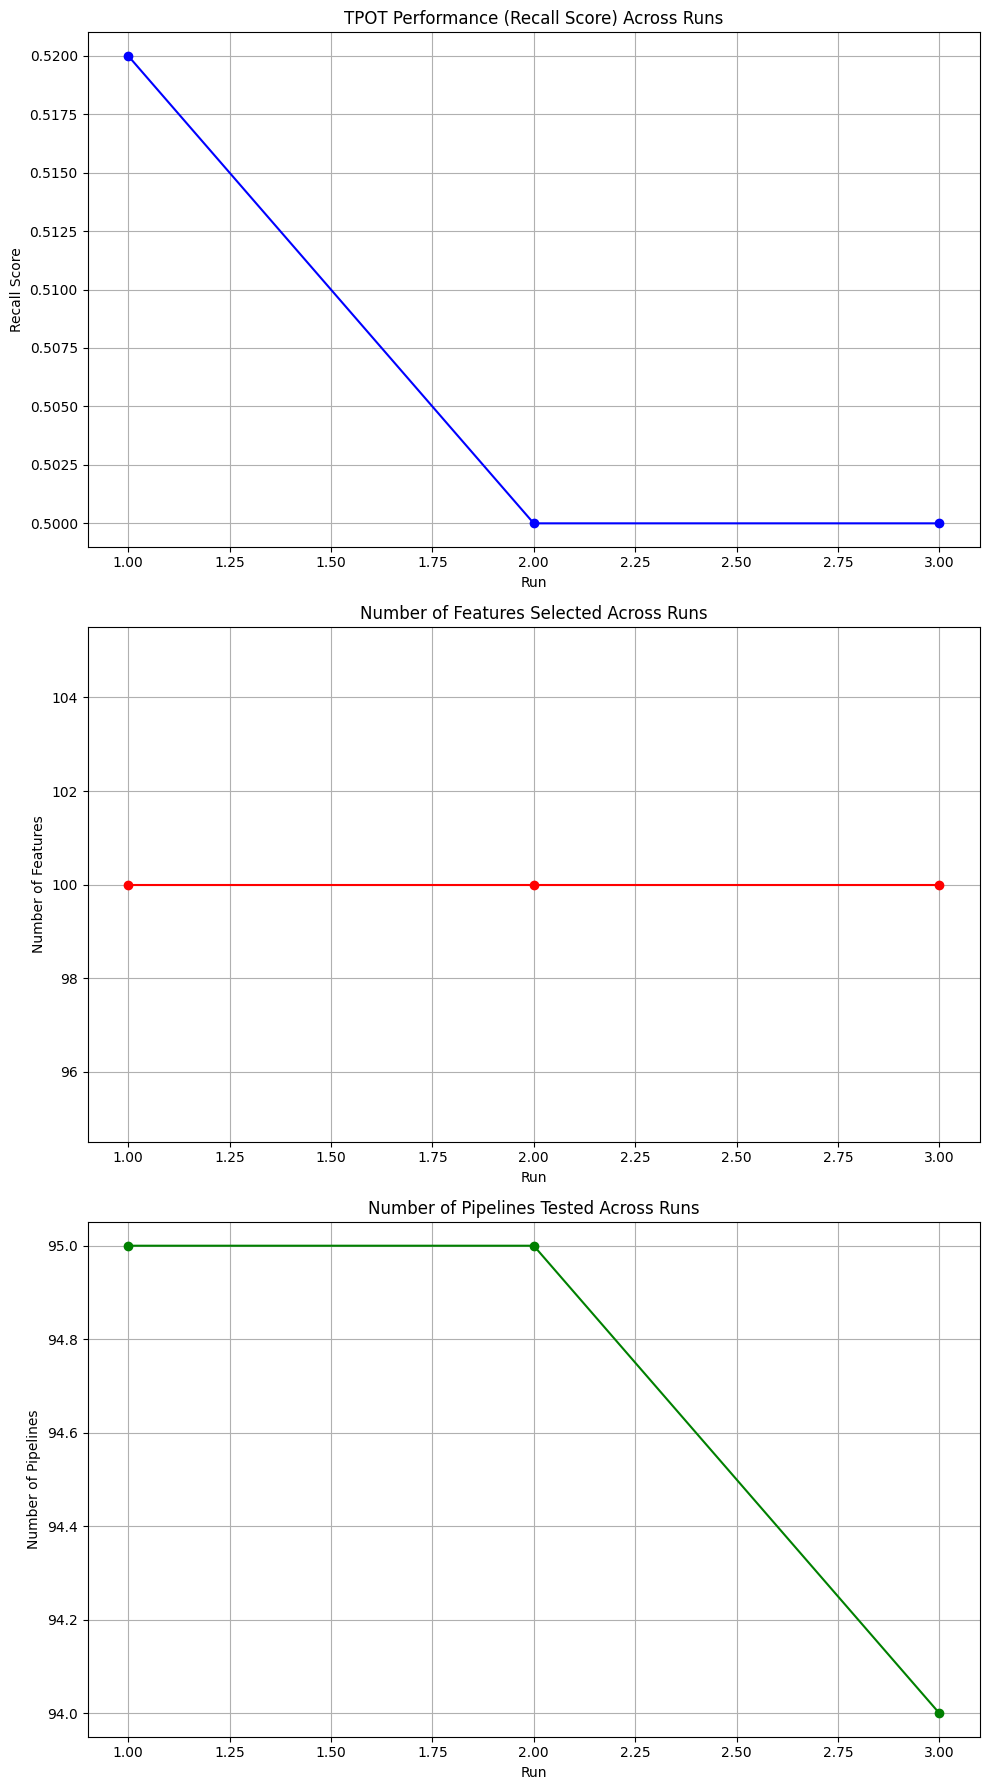

In [ ]:
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 18))

ax1.plot(results_df['run'], results_df['recall_score'], 'bo-')
ax1.set_title('TPOT Performance (Recall Score) Across Runs')
ax1.set_xlabel('Run')
ax1.set_ylabel('Recall Score')
ax1.grid(True)

ax2.plot(results_df['run'], results_df['n_features'], 'ro-')
ax2.set_title('Number of Features Selected Across Runs')
ax2.set_xlabel('Run')
ax2.set_ylabel('Number of Features')
ax2.grid(True)

# Changed this line
ax3.plot(results_df['run'], results_df['pipelines_tested'], 'go-')
ax3.set_title('Number of Pipelines Tested Across Runs')
ax3.set_xlabel('Run')
ax3.set_ylabel('Number of Pipelines')
ax3.grid(True)

plt.tight_layout()
plt.savefig('tpot_performance_features_pipelines.png')
plt.show()

# Handling Imbalanced Data

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, average_precision_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import QuantileTransformer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline


# Encode labels
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['label'])

# Split data
X = np.array(df['message_vector'].tolist())
y = df['label_encoded'].values

# Split data for this run
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Feature selection
feature_selector = RFECV(
    estimator=RandomForestClassifier(n_estimators=10, class_weight='balanced', random_state=42),
    step=5000,
    min_features_to_select=1000,
    cv=3,
    scoring='balanced_accuracy',
    n_jobs=-1
)


# Quantile transformer
quantile_transformer = QuantileTransformer(n_quantiles=1000, output_distribution='normal', random_state=42)

# Dimensionality reduction
pca = PCA(n_components=0.95)

# Create the pipeline
pipeline = ImbPipeline([
    ('feature_selection', feature_selector),
    ('quantile_transform', quantile_transformer),
    ('pca', pca),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(class_weight='balanced', random_state=42))
])

# Fit the pipeline and make predictions
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

# Calculate metrics
balanced_acc = balanced_accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, pipeline.predict_proba(X_test)[:, 1])
avg_precision = average_precision_score(y_test, pipeline.predict_proba(X_test)[:, 1])

print(f"Balanced Accuracy: {balanced_acc:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"Average Precision: {avg_precision:.4f}")

# Cross-validation
cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='balanced_accuracy')
print(f"Cross-validation Balanced Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

Balanced Accuracy: 0.6000
ROC AUC: 0.9933
Average Precision: 0.9999
Cross-validation Balanced Accuracy: 0.7230 (+/- 0.1013)


In [ ]:
# Fit the feature selector and print the number of selected features
feature_selector.fit(X_train, y_train)
print(f"Number of features selected: {feature_selector.n_features_}")

Number of features selected: 25000


# Testing the predictions

In [ ]:
test_message_benign = random_good_message
test_message_bad = random_bad_message


from tokenizers import Tokenizer
import torch
import numpy as np
import polars as pl
import numpy as np

# Load the custom tokenizer
tokenizer = Tokenizer.from_file("log_tokenizer.json")

# Define the device (assuming you're using PyTorch and want to specify CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vector_good = vectorize_text(test_message_benign).flatten()
print(len(vector_good))


# Assuming 'vector' is your input
vector_good = np.array(vector_good)
vector_2d_good = vector_good.reshape(1, -1)

# Class prediction
prediction = pipeline.predict(vector_2d_good)
print("Predicted class:", prediction[0])

# Probability prediction
probabilities = pipeline.predict_proba(vector_2d_good)
print("Class probabilities:", probabilities[0])


vector_bad = vectorize_text(test_message_bad).flatten()
print(len(vector_bad))

# Assuming 'vector' is your input
vector_bad = np.array(vector_bad)
vector_2d_bad = vector_bad.reshape(1, -1)

# Class prediction
prediction = pipeline.predict(vector_2d_bad)
print("Predicted class:", prediction[0])

# Probability prediction
probabilities = pipeline.predict_proba(vector_2d_bad)
print("Class probabilities:", probabilities[0])



30000
Predicted class: 1
Class probabilities: [0. 1.]
30000
Predicted class: 0
Class probabilities: [0.56 0.44]


# Save the Supervised Learning Model (joblib)

Generating the model can take roughly 1h of computation time on a modern 8 core / 64 GB RAM server.

In [ ]:
import joblib
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score


# Save the model using joblib
model_filename = 'manual_model_1.joblib'
joblib.dump(pipeline, model_filename)

print(f"\nModel exported as joblib: {model_filename}")


# Verify the saved model
try:
    loaded_model = joblib.load(model_filename)
except Exception as e:
    print(f"\nError verifying saved model: {str(e)}")

# Print information about how to use the saved model
print("\nTo use the saved model in the future:")
print("1. Load the model: loaded_model = joblib.load('best_tpot_nn_model.joblib')")
print("2. Make predictions: predictions = loaded_model.predict(X)")
print("Note: Make sure to preprocess your input data (X) the same way as during training.")


Model exported as joblib: manual_model_123.joblib

To use the saved model in the future:
1. Load the model: loaded_model = joblib.load('best_tpot_nn_model.joblib')
2. Make predictions: predictions = loaded_model.predict(X)
Note: Make sure to preprocess your input data (X) the same way as during training.


# Confusion matrix

<Figure size 1000x700 with 0 Axes>

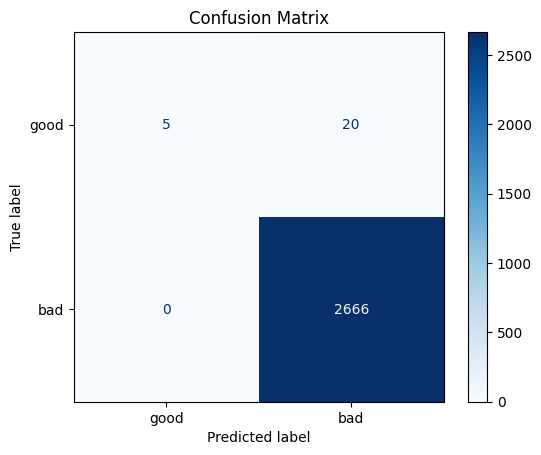

Confusion Matrix:
[[   5   20]
 [   0 2666]]

Precision: 0.9926
Recall: 1.0000
F1-score: 0.9963


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Make predictions
y_pred = pipeline.predict(X_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a ConfusionMatrixDisplay object
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['good', 'bad'])

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Calculate and print additional metrics
tn, fp, fn, tp = cm.ravel()
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)

print(f"\nPrecision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1_score:.4f}")

# CV scores

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, average_precision_score
import numpy as np

# Define the number of folds
n_splits = 5

# Create a StratifiedKFold object
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize lists to store the scores
balanced_accuracy_scores = []
roc_auc_scores = []
average_precision_scores = []

# Perform cross-validation manuall
for fold, (train_index, val_index) in enumerate(skf.split(X, y), 1):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Fit the pipeline
    pipeline.fit(X_train, y_train)

    # Make predictions
    y_pred = pipeline.predict(X_val)
    y_pred_proba = pipeline.predict_proba(X_val)[:, 1]

    # Calculate scores
    balanced_accuracy_scores.append(balanced_accuracy_score(y_val, y_pred))
    roc_auc_scores.append(roc_auc_score(y_val, y_pred_proba))
    average_precision_scores.append(average_precision_score(y_val, y_pred_proba))

    print(f"Fold {fold}:")
    print(f"  Balanced Accuracy: {balanced_accuracy_scores[-1]:.4f}")
    print(f"  ROC AUC: {roc_auc_scores[-1]:.4f}")
    print(f"  Average Precision: {average_precision_scores[-1]:.4f}")

# Print the overall results
print("\nCross-validation results:")
print(f"Balanced Accuracy: {np.mean(balanced_accuracy_scores):.4f} (+/- {np.std(balanced_accuracy_scores) * 2:.4f})")
print(f"ROC AUC: {np.mean(roc_auc_scores):.4f} (+/- {np.std(roc_auc_scores) * 2:.4f})")
print(f"Average Precision: {np.mean(average_precision_scores):.4f} (+/- {np.std(average_precision_scores) * 2:.4f})")

Fold 1:
  Balanced Accuracy: 0.7493
  ROC AUC: 0.9968
  Average Precision: 1.0000
Fold 2:
  Balanced Accuracy: 0.7605
  ROC AUC: 0.9944
  Average Precision: 0.9999
Fold 3:
  Balanced Accuracy: 0.7172
  ROC AUC: 0.9915
  Average Precision: 0.9999
Fold 4:
  Balanced Accuracy: 0.7170
  ROC AUC: 0.9932
  Average Precision: 0.9999
Fold 5:
  Balanced Accuracy: 0.6953
  ROC AUC: 0.9957
  Average Precision: 1.0000

Cross-validation results:
Balanced Accuracy: 0.7278 (+/- 0.0475)
ROC AUC: 0.9943 (+/- 0.0037)
Average Precision: 0.9999 (+/- 0.0000)


# Grid search optimization

In [ ]:
from sklearn.model_selection import cross_val_score
import itertools

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Generate all combinations of parameters
param_combinations = list(itertools.product(*param_grid.values()))

best_score = -float('inf')
best_params = None

# Manually perform grid search
for params in param_combinations:
    # Create a new pipeline with current parameters
    current_pipeline = Pipeline([
        ('smote', SMOTE(sampling_strategy=0.35, random_state=42)),
        ('undersampler', RandomUnderSampler(sampling_strategy=1.0, random_state=42)),
        ('classifier', RandomForestClassifier(
            n_estimators=params[0],
            max_depth=params[1],
            min_samples_split=params[2],
            min_samples_leaf=params[3],
            class_weight='balanced',
            random_state=42
        ))
    ])

    # Perform cross-validation
    scores = cross_val_score(current_pipeline, X, y, cv=5, scoring='balanced_accuracy')
    mean_score = scores.mean()

    # Update best score and parameters if current is better
    if mean_score > best_score:
        best_score = mean_score
        best_params = params

    print(f"Parameters: {params}, Score: {mean_score}")

print(f"\nBest parameters: {best_params}")
print(f"Best cross-validation score: {best_score}")

# Create the best pipeline
best_pipeline = Pipeline([
    ('smote', SMOTE(sampling_strategy=0.35, random_state=42)),
    ('undersampler', RandomUnderSampler(sampling_strategy=1.0, random_state=42)),
    ('classifier', RandomForestClassifier(
        n_estimators=best_params[0],
        max_depth=best_params[1],
        min_samples_split=best_params[2],
        min_samples_leaf=best_params[3],
        class_weight='balanced',
        random_state=42
    ))
])

# Fit the best pipeline
best_pipeline.fit(X, y)

Parameters: (100, None, 2, 1), Score: 0.6601958996148235
Parameters: (100, None, 2, 2), Score: 0.6575723238043774
Parameters: (100, None, 2, 4), Score: 0.6832200924981155
Parameters: (100, None, 5, 1), Score: 0.6550882823515521
Parameters: (100, None, 5, 2), Score: 0.6617703512425128
Parameters: (100, None, 5, 4), Score: 0.6832200924981155
Parameters: (100, None, 10, 1), Score: 0.6531768364259575
Parameters: (100, None, 10, 2), Score: 0.6652185568886595
Parameters: (100, None, 10, 4), Score: 0.6606836474980943
Parameters: (100, 10, 2, 1), Score: 0.7538128573575538
Parameters: (100, 10, 2, 2), Score: 0.7490530042380288
Parameters: (100, 10, 2, 4), Score: 0.7528384007866634
Parameters: (100, 10, 5, 1), Score: 0.7531383491639173
Parameters: (100, 10, 5, 2), Score: 0.7575612641582747
Parameters: (100, 10, 5, 4), Score: 0.7528384007866634
Parameters: (100, 10, 10, 1), Score: 0.7454542837406529
Parameters: (100, 10, 10, 2), Score: 0.7450421584057931
Parameters: (100, 10, 10, 4), Score: 0.745

Pipeline(steps=[('smote', SMOTE(random_state=42, sampling_strategy=0.35)),
                ('undersampler',
                 RandomUnderSampler(random_state=42, sampling_strategy=1.0)),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced', max_depth=10,
                                        min_samples_leaf=2, min_samples_split=5,
                                        random_state=42))])

In [ ]:
"""
Pipeline(steps=[('smote', SMOTE(random_state=42, sampling_strategy=0.35)),
                ('undersampler',
                 RandomUnderSampler(random_state=42, sampling_strategy=1.0)),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced', max_depth=10,
                                        min_samples_leaf=2, min_samples_split=5,
                                        random_state=42))])

SMOTE
SMOTE(random_state=42, sampling_strategy=0.35)

RandomUnderSampler
RandomUnderSampler(random_state=42, sampling_strategy=1.0)

RandomForestClassifier
RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=2, min_samples_split=5,
                       random_state=42)
"""

from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, balanced_accuracy_score

# Assuming you have your features X and target y already defined
# Encode labels
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['label'])

# Split data
X = np.array(df['message_vector'].tolist())
y = df['label_encoded'].values


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the pipeline using make_pipeline
pipeline = make_pipeline(
    SMOTE(random_state=42, sampling_strategy=0.35),
    RandomUnderSampler(random_state=42, sampling_strategy=1.0),
    RandomForestClassifier(
        class_weight='balanced',
        max_depth=10,
        min_samples_leaf=2,
        min_samples_split=5,
        random_state=42
    )
)

# Fit the pipeline
pipeline.fit(X_train, y_train)

# Use the fitted pipeline to make predictions
y_pred = pipeline.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))
print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred)}")

              precision    recall  f1-score   support

           0       0.78      0.72      0.75        25
           1       1.00      1.00      1.00      2666

    accuracy                           1.00      2691
   macro avg       0.89      0.86      0.87      2691
weighted avg       1.00      1.00      1.00      2691

Balanced Accuracy: 0.8590622655663915


<Figure size 1000x700 with 0 Axes>

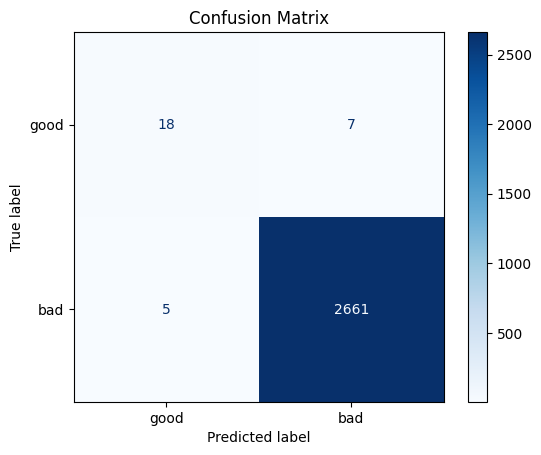

Confusion Matrix:
[[  18    7]
 [   5 2661]]

Precision: 0.9974
Recall: 0.9981
F1-score: 0.9978


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Make predictions
y_pred = pipeline.predict(X_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a ConfusionMatrixDisplay object
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['good', 'bad'])

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Calculate and print additional metrics
tn, fp, fn, tp = cm.ravel()
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)

print(f"\nPrecision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1_score:.4f}")

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, average_precision_score
import numpy as np

# Define the number of folds
n_splits = 5

# Create a StratifiedKFold object
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize lists to store the scores
balanced_accuracy_scores = []
roc_auc_scores = []
average_precision_scores = []

# Perform cross-validation manually
for fold, (train_index, val_index) in enumerate(skf.split(X, y), 1):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Fit the pipeline
    pipeline.fit(X_train, y_train)

    # Make predictions
    y_pred = pipeline.predict(X_val)
    y_pred_proba = pipeline.predict_proba(X_val)[:, 1]

    # Calculate scores
    balanced_accuracy_scores.append(balanced_accuracy_score(y_val, y_pred))
    roc_auc_scores.append(roc_auc_score(y_val, y_pred_proba))
    average_precision_scores.append(average_precision_score(y_val, y_pred_proba))

    print(f"Fold {fold}:")
    print(f"  Balanced Accuracy: {balanced_accuracy_scores[-1]:.4f}")
    print(f"  ROC AUC: {roc_auc_scores[-1]:.4f}")
    print(f"  Average Precision: {average_precision_scores[-1]:.4f}")

# Print the overall results
print("\nCross-validation results:")
print(f"Balanced Accuracy: {np.mean(balanced_accuracy_scores):.4f} (+/- {np.std(balanced_accuracy_scores) * 2:.4f})")
print(f"ROC AUC: {np.mean(roc_auc_scores):.4f} (+/- {np.std(roc_auc_scores) * 2:.4f})")
print(f"Average Precision: {np.mean(average_precision_scores):.4f} (+/- {np.std(average_precision_scores) * 2:.4f})")

Fold 1:
  Balanced Accuracy: 0.9761
  ROC AUC: 0.9994
  Average Precision: 1.0000
Fold 2:
  Balanced Accuracy: 0.8679
  ROC AUC: 0.9965
  Average Precision: 1.0000
Fold 3:
  Balanced Accuracy: 0.8686
  ROC AUC: 0.9984
  Average Precision: 1.0000
Fold 4:
  Balanced Accuracy: 0.8692
  ROC AUC: 0.9970
  Average Precision: 1.0000
Fold 5:
  Balanced Accuracy: 0.9115
  ROC AUC: 0.9979
  Average Precision: 1.0000

Cross-validation results:
Balanced Accuracy: 0.8987 (+/- 0.0843)
ROC AUC: 0.9979 (+/- 0.0020)
Average Precision: 1.0000 (+/- 0.0000)


In [ ]:
test_message_benign = random_good_message
test_message_bad = random_bad_message


from tokenizers import Tokenizer
import torch
import numpy as np
import polars as pl
import numpy as np

# Load the custom tokenizer
tokenizer = Tokenizer.from_file("log_tokenizer.json")

# Define the device (assuming you're using PyTorch and want to specify CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vector_good = vectorize_text(test_message_benign).flatten()
print(len(vector_good))


# Assuming 'vector' is your input
vector_good = np.array(vector_good)
vector_2d_good = vector_good.reshape(1, -1)

# Class prediction
prediction = pipeline.predict(vector_2d_good)
print("Predicted class:", prediction[0])

# Probability prediction
probabilities = pipeline.predict_proba(vector_2d_good)
print("Class probabilities:", probabilities[0])


vector_bad = vectorize_text(test_message_bad).flatten()
print(len(vector_bad))

# Assuming 'vector' is your input
vector_bad = np.array(vector_bad)
vector_2d_bad = vector_bad.reshape(1, -1)

# Class prediction
prediction = pipeline.predict(vector_2d_bad)
print("Predicted class:", prediction[0])

# Probability prediction
probabilities = pipeline.predict_proba(vector_2d_bad)
print("Class probabilities:", probabilities[0])



30000
Predicted class: 1
Class probabilities: [0. 1.]
30000
Predicted class: 0
Class probabilities: [0.68148054 0.31851946]


# Building a Supervised Learning classifier with Tpot (scikit Algorithms) - or an imbalanced dataset

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from tpot import TPOTClassifier
from sklearn.decomposition import TruncatedSVD

def print_step_info(X, y, step_name):
    print(f"\n--- {step_name} ---")
    print(f"X shape: {X.shape}")
    print(f"y shape: {y.shape}")
    print(f"Class distribution: {np.bincount(y)}")

def custom_scorer(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    if (tp + fn) == 0 or (tn + fp) == 0:
        return 0.0
    recall = tp / (tp + fn + 1e-8)
    specificity = tn / (tn + fp + 1e-8)
    recall_weight = 1.0
    specificity_weight = 2.0
    score = (recall_weight * recall + specificity_weight * specificity) / (recall_weight + specificity_weight)
    return score

custom_scorer_obj = make_scorer(custom_scorer, greater_is_better=True)

# Assuming you have your features X and target y already defined
# Encode labels
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['label'])

# Split data
X = np.array(df['message_vector'].tolist())
y = df['label_encoded'].values

print_step_info(X, y, "Original Data")

# Step 1: Preprocessing
imputer = SimpleImputer(strategy='mean')
scaler = StandardScaler()
pca = TruncatedSVD(n_components=100, random_state=42)  # Reduce to 100 components

X = imputer.fit_transform(X)
X = scaler.fit_transform(X)
X = pca.fit_transform(X)

print_step_info(X, y, "After Preprocessing")

# Step 2: Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print_step_info(X_train, y_train, "Training Data")

# Step 3: Initial model on imbalanced data
initial_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42, n_jobs=-1)
initial_model.fit(X_train, y_train)
y_pred_initial = initial_model.predict(X_test)
print("\nInitial Model Performance:")
print(classification_report(y_test, y_pred_initial, zero_division=0))
print("Custom Score:", custom_scorer(y_test, y_pred_initial))

# Step 4: Resampling
smote = SMOTE(sampling_strategy=0.5, random_state=42)
rus = RandomUnderSampler(sampling_strategy=0.5, random_state=42)
X_resampled, y_resampled = rus.fit_resample(*smote.fit_resample(X_train, y_train))
print_step_info(X_resampled, y_resampled, "Resampled Data")

# Step 5: Model on resampled data
resampled_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42, n_jobs=-1)
resampled_model.fit(X_resampled, y_resampled)
y_pred_resampled = resampled_model.predict(X_test)
print("\nResampled Model Performance:")
print(classification_report(y_test, y_pred_resampled, zero_division=0))
print("Custom Score:", custom_scorer(y_test, y_pred_resampled))

# Step 6: Create a new dataset with original minority samples and top predicted minority samples
y_pred_proba = resampled_model.predict_proba(X_train)[:, 1]
minority_indices = np.where(y_train == 0)[0]
predicted_minority_indices = np.argsort(y_pred_proba)[-len(minority_indices)*10:]
selected_indices = np.union1d(minority_indices, predicted_minority_indices)

X_selected = X_train[selected_indices]
y_selected = y_train[selected_indices]
print_step_info(X_selected, y_selected, "Selected Data for Final Model")

# Step 7: Final TPOT optimization
tpot_config = {
    'sklearn.ensemble.RandomForestClassifier': {
        'n_estimators': [100, 200, 500],
        'max_depth': [None, 5, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'class_weight': ['balanced', 'balanced_subsample']
    },
    'xgboost.XGBClassifier': {
        'n_estimators': [100, 200, 500],
        'max_depth': [3, 5, 7, 9],
        'learning_rate': [0.01, 0.1, 0.3],
        'subsample': [0.5, 0.7, 1.0],
        'scale_pos_weight': [1, 10, 100]
    },
    'imblearn.ensemble.BalancedRandomForestClassifier': {
        'n_estimators': [100, 200, 500],
        'replacement': [True, False]
    },
    'imblearn.ensemble.EasyEnsembleClassifier': {
        'n_estimators': [10, 20, 30, 50],
        'replacement': [True, False]
    }
}

tpot = TPOTClassifier(
    config_dict=tpot_config,
    generations=1,
    population_size=20,
    verbosity=2,
    scoring=custom_scorer_obj,
    random_state=42,
    n_jobs=-1,
    max_time_mins=60,
    max_eval_time_mins=10
)

try:
    tpot.fit(X_selected, y_selected)
    y_pred_tpot = tpot.predict(X_test)
    print("\nTPOT Model Performance:")
    print(classification_report(y_test, y_pred_tpot, zero_division=0))
    print("Custom Score:", custom_scorer(y_test, y_pred_tpot))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred_tpot))
    tpot.export('tpot_best_pipeline.py')
    print("\nBest pipeline exported to 'tpot_best_pipeline.py'")
except Exception as e:
    print(f"An error occurred during TPOT optimization: {str(e)}")

# Final evaluation
print("\nFinal Evaluation:")
print("Initial Model Custom Score:", custom_scorer(y_test, y_pred_initial))
print("Resampled Model Custom Score:", custom_scorer(y_test, y_pred_resampled))
if 'y_pred_tpot' in locals():
    print("TPOT Model Custom Score:", custom_scorer(y_test, y_pred_tpot))


--- Original Data ---
X shape: (13455, 30000)
y shape: (13455,)
Class distribution: [  114 13341]

--- After Preprocessing ---
X shape: (13455, 100)
y shape: (13455,)
Class distribution: [  114 13341]

--- Training Data ---
X shape: (10764, 100)
y shape: (10764,)
Class distribution: [   91 10673]

Initial Model Performance:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        23
           1       0.99      1.00      1.00      2668

    accuracy                           0.99      2691
   macro avg       0.50      0.50      0.50      2691
weighted avg       0.98      0.99      0.99      2691

Custom Score: 0.333333333332084

--- Resampled Data ---
X shape: (16008, 100)
y shape: (16008,)
Class distribution: [ 5336 10672]

Resampled Model Performance:
              precision    recall  f1-score   support

           0       1.00      0.22      0.36        23
           1       0.99      1.00      1.00      2668

    accuracy          

Optimization Progress:   0%|          | 0/20 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.9886446882605258

Best pipeline: BalancedRandomForestClassifier(input_matrix, n_estimators=500, replacement=False)

TPOT Model Performance:
              precision    recall  f1-score   support

           0       0.07      1.00      0.14        23
           1       1.00      0.89      0.94      2668

    accuracy                           0.89      2691
   macro avg       0.54      0.95      0.54      2691
weighted avg       0.99      0.89      0.94      2691

Custom Score: 0.9635182405885926

Confusion Matrix:
[[  23    0]
 [ 292 2376]]

Best pipeline exported to 'tpot_best_pipeline.py'

Final Evaluation:
Initial Model Custom Score: 0.333333333332084
Resampled Model Custom Score: 0.47826086950095603
TPOT Model Custom Score: 0.9635182405885926


<Figure size 1000x700 with 0 Axes>

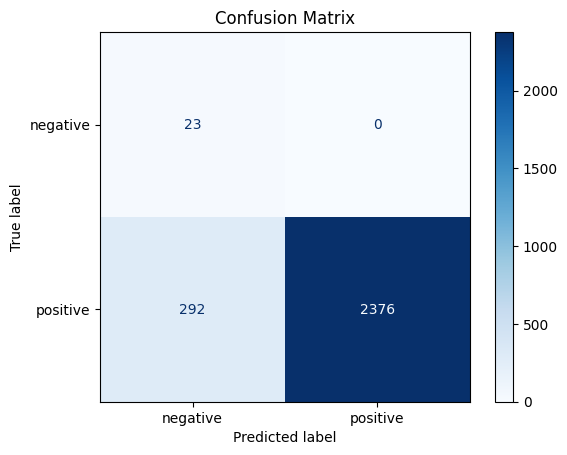

Confusion Matrix:
[[  23    0]
 [ 292 2376]]

Precision: 1.0000
Recall: 0.8906
F1-score: 0.9421


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Make predictions
y_pred = tpot.predict(X_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a ConfusionMatrixDisplay object
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['negative', 'positive'])

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Calculate and print additional metrics
tn, fp, fn, tp = cm.ravel()
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"\nPrecision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1_score:.4f}")

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, average_precision_score
import numpy as np

# Define the number of folds
n_splits = 5

# Create a StratifiedKFold object
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize lists to store the scores
balanced_accuracy_scores = []
roc_auc_scores = []
average_precision_scores = []

# Perform cross-validation
for fold, (train_index, val_index) in enumerate(skf.split(X, y), 1):
    X_val, y_val = X[val_index], y[val_index]

    # Make predictions using the existing TPOT model
    y_pred = tpot.predict(X_val)
    y_pred_proba = tpot.predict_proba(X_val)[:, 1]

    # Calculate scores
    balanced_accuracy_scores.append(balanced_accuracy_score(y_val, y_pred))
    roc_auc_scores.append(roc_auc_score(y_val, y_pred_proba))
    average_precision_scores.append(average_precision_score(y_val, y_pred_proba))

    print(f"Fold {fold}:")
    print(f"  Balanced Accuracy: {balanced_accuracy_scores[-1]:.4f}")
    print(f"  ROC AUC: {roc_auc_scores[-1]:.4f}")
    print(f"  Average Precision: {average_precision_scores[-1]:.4f}")

# Print the overall results
print("\nCross-validation results:")
print(f"Balanced Accuracy: {np.mean(balanced_accuracy_scores):.4f} (+/- {np.std(balanced_accuracy_scores) * 2:.4f})")
print(f"ROC AUC: {np.mean(roc_auc_scores):.4f} (+/- {np.std(roc_auc_scores) * 2:.4f})")
print(f"Average Precision: {np.mean(average_precision_scores):.4f} (+/- {np.std(average_precision_scores) * 2:.4f})")

Fold 1:
  Balanced Accuracy: 0.9507
  ROC AUC: 0.9996
  Average Precision: 1.0000
Fold 2:
  Balanced Accuracy: 0.9472
  ROC AUC: 0.9963
  Average Precision: 1.0000
Fold 3:
  Balanced Accuracy: 0.9400
  ROC AUC: 0.9982
  Average Precision: 1.0000
Fold 4:
  Balanced Accuracy: 0.9457
  ROC AUC: 1.0000
  Average Precision: 1.0000
Fold 5:
  Balanced Accuracy: 0.9468
  ROC AUC: 0.9956
  Average Precision: 1.0000

Cross-validation results:
Balanced Accuracy: 0.9461 (+/- 0.0069)
ROC AUC: 0.9979 (+/- 0.0035)
Average Precision: 1.0000 (+/- 0.0000)


In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import TruncatedSVD

# Assume these are saved from the training process
saved_imputer = imputer  # The SimpleImputer used in training
saved_scaler = scaler    # The StandardScaler used in training
saved_pca = pca          # The TruncatedSVD (PCA) used in training

# Vectorize the messages
vector1 = vectorize_text(random_good_message)
vector2 = vectorize_text(random_bad_message)

print("Shape of vector1:", vector1.shape)
print("Shape of vector2:", vector2.shape)

# Combine the vectors
X_new = np.vstack((vector1, vector2))

print("Shape of X_new before preprocessing:", X_new.shape)

# Apply the saved preprocessing steps
X_new = saved_imputer.transform(X_new)
print("Shape after imputation:", X_new.shape)

X_new = saved_scaler.transform(X_new)
print("Shape after scaling:", X_new.shape)

X_new = saved_pca.transform(X_new)
print("Shape after PCA:", X_new.shape)

# Ensure X_new has exactly 100 features
assert X_new.shape[1] == 100, f"X_new has {X_new.shape[1]} features instead of 100"

# Make predictions using your TPOT model
predictions = tpot.predict(X_new)
probabilities = tpot.predict_proba(X_new)

# Print results
for i, (pred, prob) in enumerate(zip(predictions, probabilities)):
    print(f"Message {i+1}:")
    print(f"Predicted class: {pred}")
    print(f"Class probabilities: {prob}")
    print()

# Print the shape of X_new for final confirmation
print(f"Final shape of X_new: {X_new.shape}")

Shape of vector1: (1, 30000)
Shape of vector2: (1, 30000)
Shape of X_new before preprocessing: (2, 30000)
Shape after imputation: (2, 30000)
Shape after scaling: (2, 30000)
Shape after PCA: (2, 100)
Message 1:
Predicted class: 1
Class probabilities: [0.186 0.814]

Message 2:
Predicted class: 0
Class probabilities: [0.75 0.25]

Final shape of X_new: (2, 100)


In [ ]:
from collections import defaultdict
import re
from tabulate import tabulate

# Assuming results_df is your DataFrame with all the run results

def simplify_pipeline(pipeline_str):
    # Extract the main classifier name
    classifier = re.search(r"(\w+)\(", pipeline_str).group(1)
    return classifier.lower()

# Initialize a dictionary to store all pipeline statistics
all_pipeline_stats = defaultdict(int)

# Iterate through all runs and all evaluated pipelines
for _, row in results_df.iterrows():
    for pipeline_str in row['pipelines_tested']:
        simple_pipeline = simplify_pipeline(pipeline_str)
        all_pipeline_stats[simple_pipeline] += 1

# Prepare the summary table
summary_table = [[pipeline, count] for pipeline, count in all_pipeline_stats.items()]

# Sort by count
summary_table.sort(key=lambda x: -x[1])

# Print the summary table
print("\nTop 10 Pipelines Across All Runs and Evaluations:")
print(tabulate(summary_table[:10], headers=['Pipeline', 'Count'], tablefmt='grid'))

# Building a Deep Learning NN classifier with Tpot (scikit Neural Network) - for an imbalanced dataset

In [ ]:
# File name to search for
file_name = "lab_logs_blindtest_activity_sysmon_1000samples_july_28_2024_filtered_vectors.parquet"

# Get the download URL of the specific file
# download_url = get_specific_file_from_latest_release(github_token, repository_name, file_name)
download_url = get_specific_file_from_tagged_release(github_token, repository_name, "lab", file_name)
print(download_url)

if download_url:
    local_file_path = file_name
    download_file(download_url, github_token, local_file_path)
else:
    print("File not found.")

https://api.github.com/repos/norandom/log2ml/releases/assets/182698628


  0%|          | 0.00/3.29M [00:00<?, ?iB/s]

File downloaded successfully and saved as lab_logs_blindtest_activity_sysmon_1000samples_july_28_2024_filtered_vectors.parquet


In [ ]:
# Split data
X = np.array(df['message_vector'].tolist())
y = df['label_encoded'].values

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import make_scorer, confusion_matrix, recall_score
from sklearn.decomposition import TruncatedSVD
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from tpot import TPOTClassifier
from collections import defaultdict
import time
import re
import gc

def print_step_info(X, y, step_name):
    print(f"\n--- {step_name} ---")
    print(f"X shape: {X.shape}")
    print(f"y shape: {y.shape}")
    print(f"Class distribution: {np.bincount(y)}")

def custom_scorer(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    if (tp + fn) == 0 or (tn + fp) == 0:
        return 0.0
    recall = tp / (tp + fn + 1e-8)
    specificity = tn / (tn + fp + 1e-8)
    recall_weight = 1.0
    specificity_weight = 2.0
    score = (recall_weight * recall + specificity_weight * specificity) / (recall_weight + specificity_weight)
    return score

custom_scorer_obj = make_scorer(custom_scorer, greater_is_better=True)

# Assuming df is already loaded and contains 'message_vector' and 'label' columns

# Encode labels
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['label'])

# Split data
X = np.array(df['message_vector'].tolist())
y = df['label_encoded'].values

print_step_info(X, y, "Original Data")

# Preprocessing
imputer = SimpleImputer(strategy='mean')
scaler = StandardScaler()
pca = TruncatedSVD(n_components=100, random_state=42)  # Reduce to 100 components

X = imputer.fit_transform(X)
X = scaler.fit_transform(X)
X = pca.fit_transform(X)

print_step_info(X, y, "After Preprocessing")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print_step_info(X_train, y_train, "Training Data")

# Resampling
smote = SMOTE(sampling_strategy=0.5, random_state=42)
rus = RandomUnderSampler(sampling_strategy=0.5, random_state=42)
X_resampled, y_resampled = rus.fit_resample(*smote.fit_resample(X_train, y_train))
print_step_info(X_resampled, y_resampled, "Resampled Data")

# TPOT configuration for neural networks
tpot_config = {
    'sklearn.neural_network.MLPClassifier': {
        'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
        'activation': ['relu', 'tanh'],
        'alpha': [0.0001, 0.001, 0.01],
        'learning_rate': ['constant', 'adaptive'],
    }
}

# Initialize results storage
results = defaultdict(list)

# Number of runs
n_runs = 3

# Initialize best_tpot and best_recall
best_tpot = None
best_recall = 0

for run in range(n_runs):
    print(f"\nStarting run {run + 1}/{n_runs}")
    start_time = time.time()

    # Initialize TPOT
    tpot = TPOTClassifier(
        config_dict=tpot_config,
        generations=5,
        population_size=20,
        verbosity=2,
        scoring=custom_scorer_obj,
        random_state=42 + run,
        n_jobs=-1,
        max_time_mins=120,
        max_eval_time_mins=20
    )

    try:
        # Fit TPOT
        tpot.fit(X_resampled, y_resampled)

        # Make predictions
        y_pred = tpot.predict(X_test)

        # Calculate recall score
        recall = recall_score(y_test, y_pred, average='macro')

        # Update best_tpot if this run has better recall score
        if recall > best_recall:
            best_recall = recall
            best_tpot = tpot

        # Get pipeline string
        pipeline_str = str(tpot.fitted_pipeline_)

        # Store results
        results['run'].append(run + 1)
        results['recall_score'].append(recall)
        results['best_pipeline'].append(pipeline_str)
        results['runtime'].append(time.time() - start_time)
        results['pipelines_tested'].append(len(tpot.evaluated_individuals_))

        print(f"Run {run + 1} completed. Recall Score: {recall:.4f}, Pipelines tested: {len(tpot.evaluated_individuals_)}")

    except Exception as e:
        print(f"An error occurred during TPOT optimization: {str(e)}")

    # Clear memory
    gc.collect()

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Save results to CSV
results_df.to_csv('tpot_nn_recall_results.csv', index=False)

print("\nResults saved to 'tpot_nn_recall_results.csv'")

# If best_tpot exists, export the best pipeline
if best_tpot:
    best_tpot.export('tpot_nn_best_pipeline.py')
    print("Best pipeline exported to 'tpot_nn_best_pipeline.py'")


--- Original Data ---
X shape: (13455, 30000)
y shape: (13455,)
Class distribution: [  114 13341]

--- After Preprocessing ---
X shape: (13455, 100)
y shape: (13455,)
Class distribution: [  114 13341]

--- Training Data ---
X shape: (10764, 100)
y shape: (10764,)
Class distribution: [   91 10673]

--- Resampled Data ---
X shape: (16008, 100)
y shape: (16008,)
Class distribution: [ 5336 10672]

Starting run 1/3


Optimization Progress:   0%|          | 0/20 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.9990629684585782

Generation 2 - Current best internal CV score: 0.9990629830910078

Generation 3 - Current best internal CV score: 0.9990629830910078

Generation 4 - Current best internal CV score: 0.9990629830910078

Generation 5 - Current best internal CV score: 0.9990629977234378

Best pipeline: MLPClassifier(MLPClassifier(input_matrix, activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=adaptive), activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=adaptive)
Run 1 completed. Recall Score: 0.8250, Pipelines tested: 89

Starting run 2/3


Optimization Progress:   0%|          | 0/20 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.9992815476935497

Generation 2 - Current best internal CV score: 0.9992815476935497

Generation 3 - Current best internal CV score: 0.9992815476935497

Generation 4 - Current best internal CV score: 0.9992815476935497

Generation 5 - Current best internal CV score: 0.9993127732985456

Best pipeline: MLPClassifier(MLPClassifier(input_matrix, activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive), activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive)
Run 2 completed. Recall Score: 0.9119, Pipelines tested: 95

Starting run 3/3


Optimization Progress:   0%|          | 0/20 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.999062924561289

Generation 2 - Current best internal CV score: 0.9991254196685702

Generation 3 - Current best internal CV score: 0.9991254196685702

Generation 4 - Current best internal CV score: 0.9991254196685702

Generation 5 - Current best internal CV score: 0.9991254343009999

Best pipeline: MLPClassifier(MLPClassifier(input_matrix, activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant), activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=adaptive)
Run 3 completed. Recall Score: 0.8025, Pipelines tested: 95

Results saved to 'tpot_nn_recall_results.csv'
Best pipeline exported to 'tpot_nn_best_pipeline.py'



Summary Statistics:
       run  recall_score     runtime  pipelines_tested
count  3.0      3.000000    3.000000          3.000000
mean   2.0      0.846452  482.763048         93.000000
std    1.0      0.057801   26.729168          3.464102
min    1.0      0.802474  459.580693         89.000000
25%    1.5      0.813718  468.144446         92.000000
50%    2.0      0.824963  476.708200         95.000000
75%    2.5      0.868441  494.354225         95.000000
max    3.0      0.911919  512.000251         95.000000

Recall Score Analysis:
  Mean: 0.8465
  Standard Deviation: 0.0578
  95.0% Confidence Interval: (0.7029, 0.9900)

One-sample t-test (comparing to baseline recall of 0.5):
  t-statistic: 10.3818
  p-value: 0.0092

Shapiro-Wilk test for normality of recall scores:
  p-value: 0.3739
  Recall scores are normally distributed

Effect size (Cohen's d) compared to baseline: 5.9939


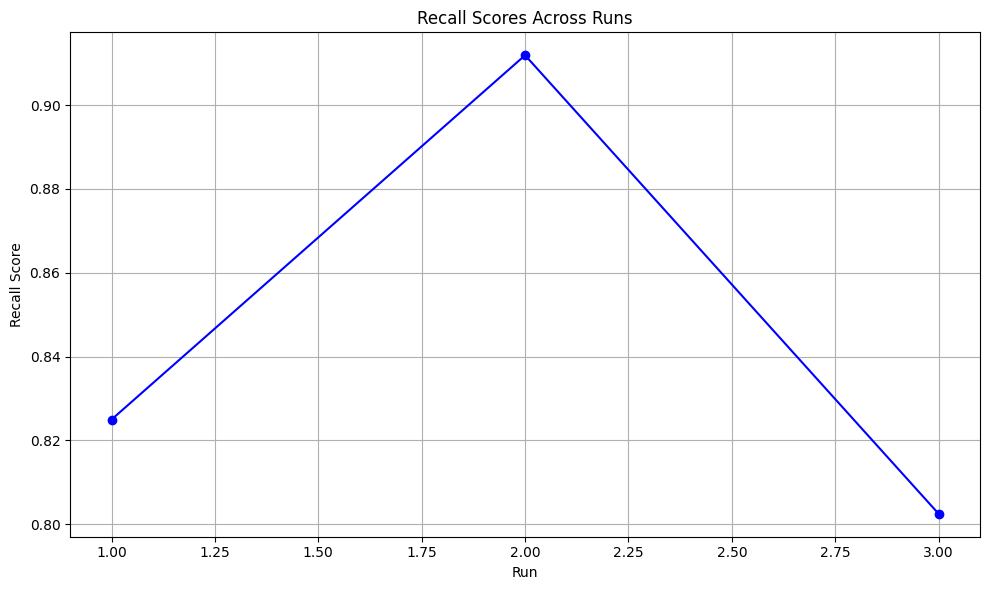


Runtime Analysis:
  Total Runtime: 1448.29 seconds
  Average Runtime per Run: 482.76 seconds

Pipelines Tested Analysis:
  Total Pipelines Tested: 279
  Average Pipelines per Run: 93.00

Best Run (Run 2):
  Recall Score: 0.9119
  Runtime: 512.00 seconds
  Pipelines Tested: 95
  Best Pipeline:
Pipeline(steps=[('stackingestimator',
                 StackingEstimator(estimator=MLPClassifier(activation='tanh',
                                                           alpha=0.01,
                                                           hidden_layer_sizes=(100,
                                                                               50),
                                                           learning_rate='adaptive',
                                                           random_state=43))),
                ('mlpclassifier',
                 MLPClassifier(alpha=0.01, hidden_layer_sizes=(100, 50),
                               learning_rate='adaptive', random_state=43))])


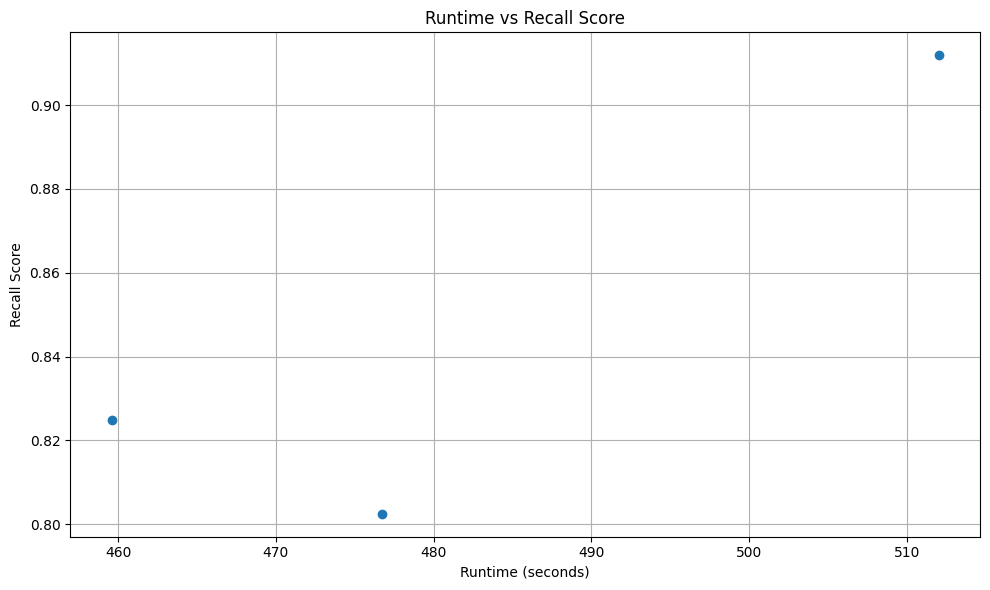


Correlation between runtime and recall score: 0.8669


In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# Assuming results_df is already loaded from 'tpot_nn_recall_results.csv'
# If not, uncomment the following line:
# results_df = pd.read_csv('tpot_nn_recall_results.csv')

# Print summary statistics
print("\nSummary Statistics:")
print(results_df.describe())

# Calculate confidence intervals for recall scores
confidence_level = 0.95
recall_scores = results_df['recall_score']
recall_mean = np.mean(recall_scores)
recall_std = np.std(recall_scores, ddof=1)
recall_se = recall_std / np.sqrt(len(recall_scores))
recall_ci = stats.t.interval(confidence_level, len(recall_scores)-1, loc=recall_mean, scale=recall_se)

print(f"\nRecall Score Analysis:")
print(f"  Mean: {recall_mean:.4f}")
print(f"  Standard Deviation: {recall_std:.4f}")
print(f"  {confidence_level*100}% Confidence Interval: ({recall_ci[0]:.4f}, {recall_ci[1]:.4f})")

# Perform t-test to check if recall scores are significantly different from a baseline
baseline_recall = 0.5  # You can adjust this value based on your expectations
t_stat, p_value = stats.ttest_1samp(recall_scores, baseline_recall)
print(f"\nOne-sample t-test (comparing to baseline recall of {baseline_recall}):")
print(f"  t-statistic: {t_stat:.4f}")
print(f"  p-value: {p_value:.4f}")

# Check for normality of recall scores
_, normality_p_value = stats.shapiro(recall_scores)
print(f"\nShapiro-Wilk test for normality of recall scores:")
print(f"  p-value: {normality_p_value:.4f}")
print(f"  {'Recall scores are normally distributed' if normality_p_value > 0.05 else 'Recall scores are not normally distributed'}")

# Calculate effect size (Cohen's d) for recall scores compared to baseline
effect_size = (recall_mean - baseline_recall) / recall_std
print(f"\nEffect size (Cohen's d) compared to baseline: {effect_size:.4f}")

# Plot recall scores
plt.figure(figsize=(10, 6))
plt.plot(results_df['run'], results_df['recall_score'], 'bo-')
plt.title('Recall Scores Across Runs')
plt.xlabel('Run')
plt.ylabel('Recall Score')
plt.grid(True)
plt.tight_layout()
plt.show()

# Runtime analysis
print("\nRuntime Analysis:")
print(f"  Total Runtime: {results_df['runtime'].sum():.2f} seconds")
print(f"  Average Runtime per Run: {results_df['runtime'].mean():.2f} seconds")

# Pipelines tested analysis
print("\nPipelines Tested Analysis:")
print(f"  Total Pipelines Tested: {results_df['pipelines_tested'].sum()}")
print(f"  Average Pipelines per Run: {results_df['pipelines_tested'].mean():.2f}")

# Best pipeline
best_run = results_df.loc[results_df['recall_score'].idxmax()]
print(f"\nBest Run (Run {best_run['run']}):")
print(f"  Recall Score: {best_run['recall_score']:.4f}")
print(f"  Runtime: {best_run['runtime']:.2f} seconds")
print(f"  Pipelines Tested: {best_run['pipelines_tested']}")
print(f"  Best Pipeline:\n{best_run['best_pipeline']}")

# Plot runtime vs recall score
plt.figure(figsize=(10, 6))
plt.scatter(results_df['runtime'], results_df['recall_score'])
plt.title('Runtime vs Recall Score')
plt.xlabel('Runtime (seconds)')
plt.ylabel('Recall Score')
plt.grid(True)
plt.tight_layout()
plt.show()

# Analyze the relationship between runtime and recall score
runtime_recall_corr, _ = stats.pearsonr(results_df['runtime'], results_df['recall_score'])
print(f"\nCorrelation between runtime and recall score: {runtime_recall_corr:.4f}")

<Figure size 1000x700 with 0 Axes>

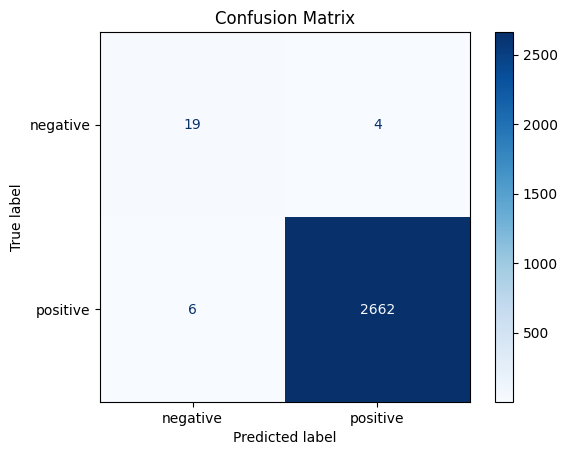

Confusion Matrix:
[[  19    4]
 [   6 2662]]

Precision: 0.9985
Recall: 0.9978
F1-score: 0.9981
Specificity: 0.8261
Custom Score: 0.8833


In [ ]:
# Make predictions
y_pred = best_tpot.predict(X_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a ConfusionMatrixDisplay object
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['negative', 'positive'])

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Calculate and print additional metrics
tn, fp, fn, tp = cm.ravel()
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"\nPrecision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1_score:.4f}")

# Additional metrics from the custom scorer
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
custom_score = (recall + 2 * specificity) / 3  # As per your custom scorer

print(f"Specificity: {specificity:.4f}")
print(f"Custom Score: {custom_score:.4f}")

Pipeline Components Frequency Table:
                            Pipeline Components  Frequency  Percentage
StackingEstimator, MLPClassifier, MLPClassifier          3       100.0


<Figure size 1200x600 with 0 Axes>

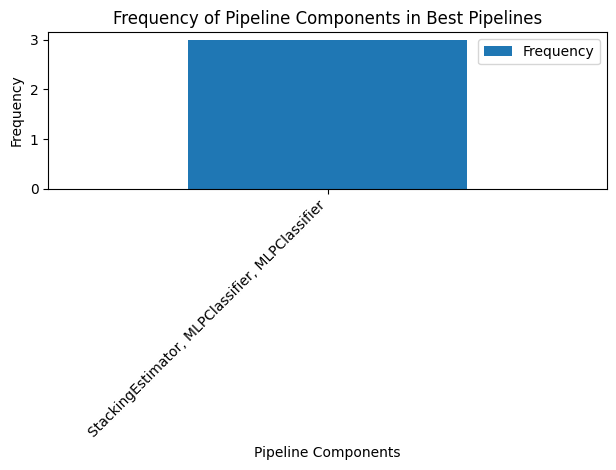


Components of the best performing pipeline: StackingEstimator, MLPClassifier, MLPClassifier

Individual Component Frequency:
MLPClassifier        6
StackingEstimator    3
Name: count, dtype: int64


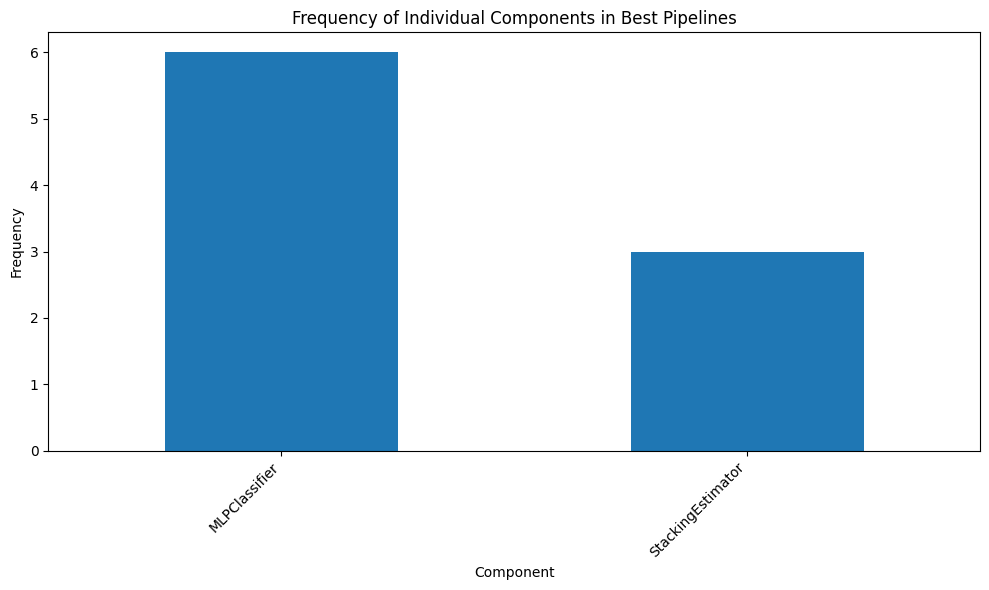


Best performing component combination: StackingEstimator, MLPClassifier, MLPClassifier
Mean recall score: 0.8465


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

# Assuming results_df is already loaded from 'tpot_nn_recall_results.csv'
# If not, uncomment the following line:
# results_df = pd.read_csv('tpot_nn_recall_results.csv')

def extract_pipeline_components(pipeline_str):
    # Extract all components from the pipeline string, excluding 'Pipeline'
    components = re.findall(r'(\w+)\(', pipeline_str)
    return ', '.join([comp for comp in components if comp != 'Pipeline'])

# Extract pipeline components
results_df['pipeline_components'] = results_df['best_pipeline'].apply(extract_pipeline_components)

# Create a table of pipeline components and their frequencies
component_counts = results_df['pipeline_components'].value_counts().reset_index()
component_counts.columns = ['Pipeline Components', 'Frequency']
component_counts['Percentage'] = component_counts['Frequency'] / len(results_df) * 100

print("Pipeline Components Frequency Table:")
print(component_counts.to_string(index=False))

# Visualize pipeline components frequency
plt.figure(figsize=(12, 6))
component_counts.plot(kind='bar', x='Pipeline Components', y='Frequency')
plt.title('Frequency of Pipeline Components in Best Pipelines')
plt.xlabel('Pipeline Components')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Find the best performing pipeline components
best_components = results_df.loc[results_df['recall_score'].idxmax(), 'pipeline_components']
print(f"\nComponents of the best performing pipeline: {best_components}")

# Analyze individual components
all_components = [comp.strip() for comps in results_df['pipeline_components'].str.split(',') for comp in comps]
component_freq = pd.Series(all_components).value_counts()

print("\nIndividual Component Frequency:")
print(component_freq)

# Visualize individual component frequency
plt.figure(figsize=(10, 6))
component_freq.plot(kind='bar')
plt.title('Frequency of Individual Components in Best Pipelines')
plt.xlabel('Component')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Additional analysis: Component combination performance
results_df['mean_recall'] = results_df.groupby('pipeline_components')['recall_score'].transform('mean')
best_combo = results_df.loc[results_df['mean_recall'].idxmax(), 'pipeline_components']
best_combo_recall = results_df.loc[results_df['mean_recall'].idxmax(), 'mean_recall']

print(f"\nBest performing component combination: {best_combo}")
print(f"Mean recall score: {best_combo_recall:.4f}")

# [Rest of the previous analysis code remains the same]

# ... [Keep all the previous analysis code] ...

In [ ]:
import joblib
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

# Find the best run (highest F1 score)
best_run_index = results_df['f1_score'].idxmax()
best_pipeline_str = results_df.loc[best_run_index, 'best_pipeline']

# Re-fit the best pipeline on the entire dataset
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_pca, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)
best_model = tpot.fitted_pipeline_

# Save the model using joblib
model_filename = 'best_tpot_nn_model.joblib'
joblib.dump(best_model, model_filename)

print(f"\nBest model exported as joblib: {model_filename}")

# You can also save the best pipeline as a Python script
python_filename = 'best_tpot_nn_pipeline.py'
best_pipeline_script = tpot.export(python_filename)

print(f"Best pipeline saved as Python script: {python_filename}")

# Print the best pipeline
print(f"\nBest Pipeline:\n{best_pipeline_str}")

# Verify the saved model
try:
    loaded_model = joblib.load(model_filename)
    y_pred = loaded_model.predict(X_test_full)
    f1 = f1_score(y_test_full, y_pred, average='weighted')
    print(f"\nLoaded model verified. F1 Score: {f1:.4f}")
except Exception as e:
    print(f"\nError verifying saved model: {str(e)}")

# Print information about how to use the saved model
print("\nTo use the saved model in the future:")
print("1. Load the model: loaded_model = joblib.load('best_tpot_nn_model.joblib')")
print("2. Make predictions: predictions = loaded_model.predict(X)")
print("Note: Make sure to preprocess your input data (X) the same way as during training.")


Best model exported as joblib: best_tpot_nn_model.joblib
Best pipeline saved as Python script: best_tpot_nn_pipeline.py

Best Pipeline:
Pipeline(steps=[('gaussiannb', GaussianNB())])

Loaded model verified. F1 Score: 0.9988

To use the saved model in the future:
1. Load the model: loaded_model = joblib.load('best_tpot_nn_model.joblib')
2. Make predictions: predictions = loaded_model.predict(X)
Note: Make sure to preprocess your input data (X) the same way as during training.


# Attempt: Building a GPU-accelerated cuML classifier with Tpot - for an imbalanced dataset

In [9]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, confusion_matrix, recall_score, accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder, QuantileTransformer
from sklearn.decomposition import TruncatedSVD
from cuml.ensemble import RandomForestClassifier
from cuml.svm import SVC
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from tpot import TPOTClassifier
import time
import gc
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

def custom_scorer(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    if (tp + fn) == 0 or (tn + fp) == 0:
        return 0.0
    recall = tp / (tp + fn + 1e-8)
    specificity = tn / (tn + fp + 1e-8)
    recall_weight = 1.0
    specificity_weight = 2.0
    score = (recall_weight * recall + specificity_weight * specificity) / (recall_weight + specificity_weight)
    return score

custom_scorer_obj = make_scorer(custom_scorer, greater_is_better=True)

# Assuming df is already loaded and contains 'message_vector' and 'label' columns

# Prepare data
X = np.array(df['message_vector'].tolist(), dtype='float32')
y = df['label'].values

# Ensure y is numeric
le = LabelEncoder()
y = le.fit_transform(y)

# Preprocessing
qt = QuantileTransformer(n_quantiles=1000, output_distribution='normal')
pca = TruncatedSVD(n_components=min(100, X.shape[1] - 1), random_state=42)
X = qt.fit_transform(X)
X = pca.fit_transform(X)

# Ensure X is float32 (required for cuML)
X = X.astype(np.float32)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Resampling
smote = SMOTE(sampling_strategy=0.5, random_state=42)
rus = RandomUnderSampler(sampling_strategy=0.5, random_state=42)
X_train, y_train = rus.fit_resample(*smote.fit_resample(X_train, y_train))

# Ensure y_train is int32 (required for cuML)
y_train = y_train.astype(np.int32)

# Custom configuration for TPOT
tpot_config = {
    'cuml.ensemble.RandomForestClassifier': {
        'n_estimators': [100, 200, 500],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2', 0.1, 0.3, 0.5],
        'class_weight': [None, 'balanced', 'balanced_subsample'],
        # 'criterion': ['gini', 'entropy'],
        'bootstrap': [True, False]
    }
}

# Initialize and run TPOT
tpot = TPOTClassifier(
    generations=5,
    population_size=20,
    cv=5,
    scoring=custom_scorer_obj,
    random_state=42,
    config_dict=tpot_config,
    verbosity=2,
    n_jobs=1,
    max_time_mins=60,
    max_eval_time_mins=5
)

start_time = time.time()
tpot.fit(X_train, y_train)
print(f"TPOT optimization completed in {time.time() - start_time:.2f} seconds")

# Evaluate the best pipeline
y_pred = tpot.predict(X_test)
recall = recall_score(y_test, y_pred, average='macro')
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp + 1e-8)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
custom_score = custom_scorer(y_test, y_pred)

print(f"Best pipeline: {tpot.fitted_pipeline_}")
print(f"Recall Score: {recall:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Custom Score: {custom_score:.4f}")

print("Confusion Matrix:")
print(cm)

# Export the best pipeline
tpot.export('tpot_best_pipeline.py')
print("Best pipeline exported to 'tpot_best_pipeline.py'")

gc.collect()

Exception ignored in: <cyfunction RandomForestClassifier.__del__ at 0x7ac2ebd6e810>
Traceback (most recent call last):
  File "randomforestclassifier.pyx", line 314, in cuml.ensemble.randomforestclassifier.RandomForestClassifier.__del__
  File "randomforestclassifier.pyx", line 318, in cuml.ensemble.randomforestclassifier.RandomForestClassifier._reset_forest_data
  File "base.pyx", line 330, in cuml.internals.base.Base.__getattr__
AttributeError: rf_forest
Exception ignored in: <cyfunction RandomForestClassifier.__del__ at 0x7ac2ebd6e810>
Traceback (most recent call last):
  File "randomforestclassifier.pyx", line 314, in cuml.ensemble.randomforestclassifier.RandomForestClassifier.__del__
  File "randomforestclassifier.pyx", line 318, in cuml.ensemble.randomforestclassifier.RandomForestClassifier._reset_forest_data
  File "base.pyx", line 330, in cuml.internals.base.Base.__getattr__
AttributeError: rf_forest
Exception ignored in: <cyfunction RandomForestClassifier.__del__ at 0x7ac2ebd6

Optimization Progress:   0%|          | 0/20 [00:00<?, ?pipeline/s]

Exception ignored in: <cyfunction RandomForestClassifier.__del__ at 0x7ac2ebd6e810>
Traceback (most recent call last):
  File "randomforestclassifier.pyx", line 314, in cuml.ensemble.randomforestclassifier.RandomForestClassifier.__del__
  File "randomforestclassifier.pyx", line 318, in cuml.ensemble.randomforestclassifier.RandomForestClassifier._reset_forest_data
  File "base.pyx", line 330, in cuml.internals.base.Base.__getattr__
AttributeError: rf_forest
Exception ignored in: <cyfunction RandomForestClassifier.__del__ at 0x7ac2ebd6e810>
Traceback (most recent call last):
  File "randomforestclassifier.pyx", line 314, in cuml.ensemble.randomforestclassifier.RandomForestClassifier.__del__
  File "randomforestclassifier.pyx", line 318, in cuml.ensemble.randomforestclassifier.RandomForestClassifier._reset_forest_data
  File "base.pyx", line 330, in cuml.internals.base.Base.__getattr__
AttributeError: rf_forest
Exception ignored in: <cyfunction RandomForestClassifier.__del__ at 0x7ac2ebd6


Generation 1 - Current best internal CV score: 0.9999062792799144


Exception ignored in: <cyfunction RandomForestClassifier.__del__ at 0x7ac2ebd6e810>
Traceback (most recent call last):
  File "randomforestclassifier.pyx", line 314, in cuml.ensemble.randomforestclassifier.RandomForestClassifier.__del__
  File "randomforestclassifier.pyx", line 318, in cuml.ensemble.randomforestclassifier.RandomForestClassifier._reset_forest_data
  File "base.pyx", line 330, in cuml.internals.base.Base.__getattr__
AttributeError: rf_forest
Exception ignored in: <cyfunction RandomForestClassifier.__del__ at 0x7ac2ebd6e810>
Traceback (most recent call last):
  File "randomforestclassifier.pyx", line 314, in cuml.ensemble.randomforestclassifier.RandomForestClassifier.__del__
  File "randomforestclassifier.pyx", line 318, in cuml.ensemble.randomforestclassifier.RandomForestClassifier._reset_forest_data
  File "base.pyx", line 330, in cuml.internals.base.Base.__getattr__
AttributeError: rf_forest
Exception ignored in: <cyfunction RandomForestClassifier.__del__ at 0x7ac2ebd6


Generation 2 - Current best internal CV score: 0.9999062792799144


Exception ignored in: <cyfunction RandomForestClassifier.__del__ at 0x7ac2ebd6e810>
Traceback (most recent call last):
  File "randomforestclassifier.pyx", line 314, in cuml.ensemble.randomforestclassifier.RandomForestClassifier.__del__
  File "randomforestclassifier.pyx", line 318, in cuml.ensemble.randomforestclassifier.RandomForestClassifier._reset_forest_data
  File "base.pyx", line 330, in cuml.internals.base.Base.__getattr__
AttributeError: rf_forest
Exception ignored in: <cyfunction RandomForestClassifier.__del__ at 0x7ac2ebd6e810>
Traceback (most recent call last):
  File "randomforestclassifier.pyx", line 314, in cuml.ensemble.randomforestclassifier.RandomForestClassifier.__del__
  File "randomforestclassifier.pyx", line 318, in cuml.ensemble.randomforestclassifier.RandomForestClassifier._reset_forest_data
  File "base.pyx", line 330, in cuml.internals.base.Base.__getattr__
AttributeError: rf_forest
Exception ignored in: <cyfunction RandomForestClassifier.__del__ at 0x7ac2ebd6


Generation 3 - Current best internal CV score: 0.9999375195173401


Exception ignored in: <cyfunction RandomForestClassifier.__del__ at 0x7ac2ebd6e810>
Traceback (most recent call last):
  File "randomforestclassifier.pyx", line 314, in cuml.ensemble.randomforestclassifier.RandomForestClassifier.__del__
  File "randomforestclassifier.pyx", line 318, in cuml.ensemble.randomforestclassifier.RandomForestClassifier._reset_forest_data
  File "base.pyx", line 330, in cuml.internals.base.Base.__getattr__
AttributeError: rf_forest
Exception ignored in: <cyfunction RandomForestClassifier.__del__ at 0x7ac2ebd6e810>
Traceback (most recent call last):
  File "randomforestclassifier.pyx", line 314, in cuml.ensemble.randomforestclassifier.RandomForestClassifier.__del__
  File "randomforestclassifier.pyx", line 318, in cuml.ensemble.randomforestclassifier.RandomForestClassifier._reset_forest_data
  File "base.pyx", line 330, in cuml.internals.base.Base.__getattr__
AttributeError: rf_forest
Exception ignored in: <cyfunction RandomForestClassifier.__del__ at 0x7ac2ebd6


Generation 4 - Current best internal CV score: 0.9999375195173401


Exception ignored in: <cyfunction RandomForestClassifier.__del__ at 0x7ac2ebd6e810>
Traceback (most recent call last):
  File "randomforestclassifier.pyx", line 314, in cuml.ensemble.randomforestclassifier.RandomForestClassifier.__del__
  File "randomforestclassifier.pyx", line 318, in cuml.ensemble.randomforestclassifier.RandomForestClassifier._reset_forest_data
  File "base.pyx", line 330, in cuml.internals.base.Base.__getattr__
AttributeError: rf_forest
Exception ignored in: <cyfunction RandomForestClassifier.__del__ at 0x7ac2ebd6e810>
Traceback (most recent call last):
  File "randomforestclassifier.pyx", line 314, in cuml.ensemble.randomforestclassifier.RandomForestClassifier.__del__
  File "randomforestclassifier.pyx", line 318, in cuml.ensemble.randomforestclassifier.RandomForestClassifier._reset_forest_data
  File "base.pyx", line 330, in cuml.internals.base.Base.__getattr__
AttributeError: rf_forest
Exception ignored in: <cyfunction RandomForestClassifier.__del__ at 0x7ac2ebd6


Generation 5 - Current best internal CV score: 0.9999375195173401

Best pipeline: RandomForestClassifier(CombineDFs(input_matrix, input_matrix), bootstrap=False, class_weight=None, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200)
TPOT optimization completed in 493.37 seconds
Best pipeline: Pipeline(steps=[('featureunion',
                 FeatureUnion(transformer_list=[('functiontransformer-1',
                                                 FunctionTransformer(func=<function copy at 0x7acc3db1f520>)),
                                                ('functiontransformer-2',
                                                 FunctionTransformer(func=<function copy at 0x7acc3db1f520>))])),
                ('randomforestclassifier', RandomForestClassifier())])
Recall Score: 0.5652
Specificity: 0.1304
Accuracy: 0.9926
F1 Score: 0.9897
Custom Score: 0.4203
Confusion Matrix:
[[   3   20]
 [   0 2668]]
Best pipeline exported to 'tpot_best_pipeline.p

2071

<Figure size 1000x700 with 0 Axes>

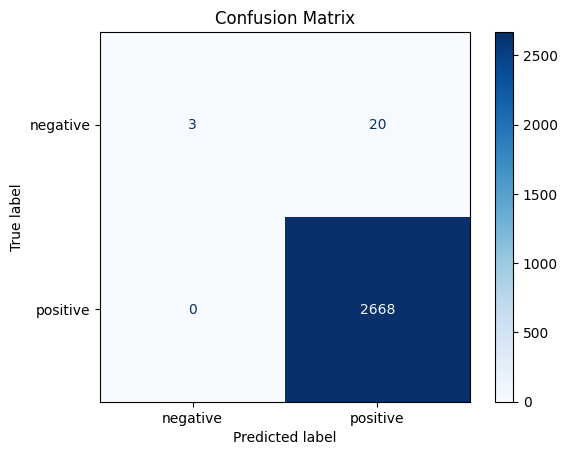

Confusion Matrix:
[[   3   20]
 [   0 2668]]

Precision: 0.9926
Recall: 1.0000
F1-score: 0.9963
Specificity: 0.1304
Custom Score: 0.4203


In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Make predictions
y_pred = tpot.predict(X_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a ConfusionMatrixDisplay object
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['negative', 'positive'])

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Calculate and print additional metrics
tn, fp, fn, tp = cm.ravel()
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"\nPrecision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1_score:.4f}")

# Additional metrics from the custom scorer
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
custom_score = (recall + 2 * specificity) / 3  # As per your custom scorer

print(f"Specificity: {specificity:.4f}")
print(f"Custom Score: {custom_score:.4f}")

In [26]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import TruncatedSVD

# Assume these are saved from the training process
# saved_imputer = imputer  # The SimpleImputer used in training


# Vectorize the messages
vector1 = vectorize_text(random_good_message)
vector2 = vectorize_text(random_bad_message)

print("Shape of vector1:", vector1.shape)
print("Shape of vector2:", vector2.shape)

# Combine the vectors
X_new = np.vstack((vector1, vector2))

print("Shape of X_new before preprocessing:", X_new.shape)


X_new = qt.transform(X_new)
print("Shape after scaling:", X_new.shape)

X_new = pca.transform(X_new)
print("Shape after PCA:", X_new.shape)

# Ensure X_new has exactly 100 features
assert X_new.shape[1] == 100, f"X_new has {X_new.shape[1]} features instead of 100"

# Make predictions using your TPOT model
predictions = tpot.predict(X_new)
probabilities = tpot.predict_proba(X_new)

print(random_bad_message)

# Print results
for i, (pred, prob) in enumerate(zip(predictions, probabilities)):
    print(f"Message {i+1}:")
    print(f"Predicted class: {pred}")
    print(f"Class probabilities: {prob}")
    print()

# Print the shape of X_new for final confirmation
print(f"Final shape of X_new: {X_new.shape}")

Shape of vector1: (1, 30000)
Shape of vector2: (1, 30000)
Shape of X_new before preprocessing: (2, 30000)
Shape after scaling: (2, 30000)
Shape after PCA: (2, 100)
File created:
RuleName: EXE
UtcTime: 2024-07-28 15:53:22.557
ProcessGuid: {18e8265a-696d-66a6-7705-000000004400}
ProcessId: 10624
Image: C:\Program Files\Microsoft Office\Root\Office16\EXCEL.EXE
TargetFilename: C:\Users\student\AppData\Local\Temp\file.exe
CreationUtcTime: 2024-07-23 14:24:50.520
Message 1:
Predicted class: 1.0
Class probabilities: [0.12708335 0.8729167 ]

Message 2:
Predicted class: 1.0
Class probabilities: [0.12375 0.87625]

Final shape of X_new: (2, 100)
